In [1]:
import time
import numpy as np
import pandas as pd
import os
import pickle as pkl
from matplotlib import pyplot as plt
from collections import defaultdict
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize

from collections import Counter

%matplotlib inline

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from keras.models import load_model

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten, Lambda
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model, load_model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers, regularizers, optimizers
from keras.callbacks import History, CSVLogger

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, auc

/home/akhil.patel1896/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
full_data = pd.read_pickle("./local/full_data.pkl")
USE_sent_embed = np.load("./local/USE_token_sentence_embeddings.npy")
full_data["USE_token_sentence_embeddings"] = USE_sent_embed.tolist()

In [3]:
full_data = full_data.reset_index()

In [4]:
full_data.tail()

,index,genres,plots,list_genres,list_genres_consol,USE_tokens,tokenized_words,USE_tokens_sentences,flattened_tokens,binarized_labels,USE_token_plot_embeddings,USE_tokens_sentences_padded,USE_token_sentence_embeddings
224298,255848,Family,The Milky Way is a groundbreaking breastfeedin...,[Family],[Family],the milky way is a groundbreaking breastfeedin...,"[[milky, way, groundbreaking, breastfeeding, d...",[the milky way is a groundbreaking breastfeedi...,"[milky, way, groundbreaking, breastfeeding, do...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[-0.0630050003528595, -0.06460414081811905, 0....",[the milky way is a groundbreaking breastfeedi...,"[[-0.058721527457237244, -0.05953942984342575,..."
224299,255849,Comedy,MLE ('My Little Eye') is based on a true story...,[Comedy],[Comedy],mle 'my little eye' is based on a true story j...,"[[mle, 'my, little, eye, ', base, true, story,...",[mle 'my little eye' is based on a true story ...,"[mle, 'my, little, eye, ', base, true, story, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[-0.0229553934186697, 0.054484546184539795, -0...",[mle 'my little eye' is based on a true story ...,"[[0.0776275023818016, 0.08402645587921143, 0.0..."
224300,255850,Drama,Helene Blair is the wife of a prominent busine...,[Drama],[Drama],helene blair is the wife of a prominent busine...,"[[helene, blair, wife, prominent, businessman,...",[helene blair is the wife of a prominent busin...,"[helene, blair, wife, prominent, businessman, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[-0.03255483880639076, 0.0390518419444561, 0.0...",[helene blair is the wife of a prominent busin...,"[[0.022109340876340866, 0.05398458614945412, 0..."
224301,255851,Action Drama,"The film is based on a state, the full moon, w...","[Action, Drama]","[Action, Drama]",the film is based on a state the full moon whi...,"[[film, base, state, full, moon, provide, oppo...",[the film is based on a state the full moon wh...,"[film, base, state, full, moon, provide, oppor...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[-0.02337327040731907, -0.026117825880646706, ...",[the film is based on a state the full moon wh...,"[[0.01855345256626606, -0.0379323735833168, -0..."
224302,255852,Comedy,The guys at Humungo Toys have a problem. The h...,[Comedy],[Comedy],the guys at humungo toys have a problem. the h...,"[[guy, humungo, toys, problem, .], [holiday, s...","[the guys at humungo toys have a problem., the...","[guy, humungo, toys, problem, ., holiday, seas...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0.07509728521108627, 0.038567110896110535, -0...","[the guys at humungo toys have a problem., the...","[[0.029480447992682457, 0.01175909023731947, -..."


## Read in train and test txt files

In [2]:
train_genres = open("train_genres.txt", encoding="utf-8").read().split('\n')
train_plots = open("train_plots.txt", encoding="utf-8").read().split('\n')

In [3]:
train_data = pd.DataFrame({"genres": train_genres, "plots": train_plots})

In [4]:
len(train_data)

204682

In [5]:
train_data.loc[4]["genres"].split(" ")

['Adventure', 'Animation', 'Comedy', '']

In [6]:
test_genres = open("test_genres.txt", encoding="utf-8").read().split('\n')
test_plots = open("test_plots.txt", encoding="utf-8").read().split('\n')

In [7]:
test_data = pd.DataFrame({"genres": test_genres, "plots": test_plots})

In [8]:
len(test_data)

51171

In [9]:
#Concat dataframes
full_data = pd.concat([train_data, test_data], ignore_index= True)

# BRIEF EDA

In [10]:
#Convert genres to list for easier analysis
def list_genres(row):
    return row["genres"].split(" ")[:-1]

In [11]:
full_data["list_genres"] = full_data.apply(lambda row: list_genres(row), axis = 1)

In [12]:
count_dict = defaultdict(int)

In [13]:
#Count num of movies per genre
def dict_count(row):
    global count_dict
    for genre in row["list_genres"]:
        count_dict[genre] += 1

In [14]:
#RUN ONLY ONCE!!!
count_val_series = full_data.apply(lambda row: dict_count(row), axis = 1)

27.88% of the movies are Comedy
45.84% of the movies are Drama
2.37% of the movies are Western
7.00% of the movies are Adventure
6.21% of the movies are Animation
9.71% of the movies are Action
11.18% of the movies are Thriller
8.08% of the movies are Family
11.01% of the movies are Romance
5.89% of the movies are Fantasy
7.77% of the movies are Horror
4.77% of the movies are History
4.95% of the movies are Music
5.60% of the movies are Sci-Fi
2.85% of the movies are War
7.27% of the movies are Crime
2.23% of the movies are Musical
5.18% of the movies are Biography
5.40% of the movies are Mystery
2.37% of the movies are Sport


[Text(0,0,'Comedy'),
 Text(0,0,'Drama'),
 Text(0,0,'Western'),
 Text(0,0,'Adventure'),
 Text(0,0,'Animation'),
 Text(0,0,'Action'),
 Text(0,0,'Thriller'),
 Text(0,0,'Family'),
 Text(0,0,'Romance'),
 Text(0,0,'Fantasy'),
 Text(0,0,'Horror'),
 Text(0,0,'History'),
 Text(0,0,'Music'),
 Text(0,0,'Sci-Fi'),
 Text(0,0,'War'),
 Text(0,0,'Crime'),
 Text(0,0,'Musical'),
 Text(0,0,'Biography'),
 Text(0,0,'Mystery'),
 Text(0,0,'Sport')]

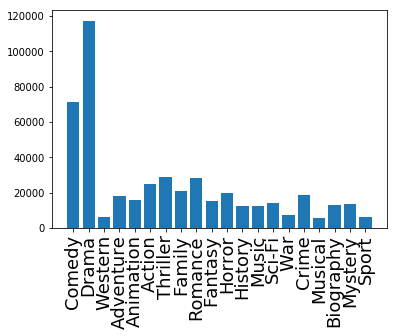

In [15]:
#Count num of movies per genre
for key,val in count_dict.items():
    print("{:0.2f}% of the movies are {}".format(100*val/len(full_data), key))



fig, ax = plt.subplots(1,1) 
ax.bar(range(len(count_dict.keys())), list(count_dict.values()))
ax.set_xticks(range(len(count_dict.keys())))
ax.set_xticklabels(list(count_dict.keys()), rotation='vertical', fontsize=18)



Avg num of genres: 1.835858872086706
Median num of genres: 1.0
Max number of genres: 11
Min number of genres: 1


(array([1.29306e+05, 6.44310e+04, 4.38940e+04, 1.29500e+04, 3.96000e+03,
        1.01100e+03, 2.36000e+02, 5.20000e+01, 6.00000e+00, 7.00000e+00]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <a list of 10 Patch objects>)

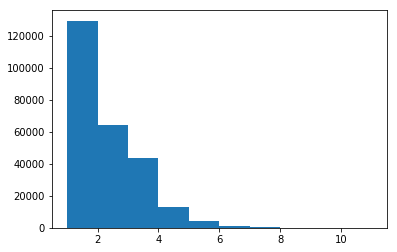

In [16]:
#Number of genres per movie
genre_labels = full_data["list_genres"].str.len()
print("Avg num of genres:", np.mean(genre_labels))
print("Median num of genres:", np.median(genre_labels))
print("Max number of genres:", np.max(genre_labels))
print("Min number of genres:", np.min(genre_labels))


plt.hist(genre_labels)

In [17]:
#average length of plot summary (characters)
avg_num_chars = train_data["plots"].str.len().mean()
max_num_chars = train_data["plots"].str.len().max()
print(f'The average number of characters in a summary is {avg_num_chars}, max is {max_num_chars}')

The average number of characters in a summary is 458.48165446888345, max is 1192


In [18]:
avg_num_words = train_data["plots"].str.count(" ").mean() + 1
max_num_words = train_data["plots"].str.count(" ").max() + 1
avg_num_periods = train_data["plots"].str.count("[\.\?!]").mean()
max_num_periods = train_data["plots"].str.count("[\.\?!]").max()
print(f'The average number of words in a summary is {avg_num_words}, max is {max_num_words}')
print(f'The average number of sentences in a summary is {avg_num_periods}, max is {max_num_periods}')
print(avg_num_words/avg_num_periods)

The average number of words in a summary is 79.8617855991245, max is 195
The average number of sentences in a summary is 4.39193969181462, max is 74
18.18371635383909


In [19]:
train_data["plots"].str.count("\n").max()

0

In [20]:
#Alternative way to calculate plot length
print(train_data["plots"].str.lower().str.split().str.len().mean()) #Avg words
print(train_data["plots"].str.lower().str.split().str.len().max()) #Max words

78.86194193920325
194


In [21]:
dict_words = Counter(" ".join(train_data["plots"]).split(" "))
print(len(dict_words.keys())) #should be number of unique words
print(sum(dict_words.values())) #should be total number of words

567468
16346270


# Preprocessing

In [22]:
#Lemmetizing Function
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return wordnet.NOUN

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/akhil.patel1896/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/akhil.patel1896/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
#Tokenize w/lemmetization AFTER removing stopwords 
#https://machinelearningmastery.com/clean-text-machine-learning-python/
def tokenize(plot, stop_words, lemmatize = False):
    
    def re_sub(pattern, replace):
        return re.sub(pattern, replace, plot)
    
    plot = plot.lower() #lowercase
    plot = re_sub(r"[-+]?[.\d]*[\d]+[:,/.\d]*", "DG") #generic tag for numbers
    plot = re_sub(r"([!?.]){2,}", r"\1") #Convert multiple punctuations to the last punctuation mark
    plot = plot.replace('-',' ') #separating hyphenated words
    plot = plot.replace('_','') #remove underscores
    plot = re_sub(r'(?<!\w)([a-zA-Z])\.', r'\1') #remove periods from abbreviations
    plot = re_sub('[^\w\s\.\?\!\']','') #remove punctuation besides sentence completers and apostrophes
    sentences = nltk.sent_tokenize(plot)
    words = list(map(nltk.word_tokenize, sentences))
    words = [[x for x in w if not x in stop_words] for w in words]

    if lemmatize:
        output_lem = [nltk.pos_tag(w) for w in words]
        return [[lemmatizer.lemmatize(x[0], pos = nltk2wn_tag(x[1])) for x in w] for w in output_lem]
    else:
        return words

In [25]:
nltk.download('punkt')
nltk.download('stopwords')
stop = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/akhil.patel1896/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/akhil.patel1896/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
start = time.time()
full_data['tokenized_words'] = full_data.apply(lambda row: tokenize(row['plots'], stop, lemmatize = True), axis=1)
end = time.time()
print("Total Time to tokenize plots:", end - start, "seconds")

Total Time to tokenize plots: 1484.1539039611816 seconds


In [29]:
full_data['flattened_tokens'] = full_data.apply(lambda l: [item for sublist in l['tokenized_words'] for item in sublist], axis=1)

# Binarize labels

In [5]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(full_data["list_genres_consol"])
full_data["binarized_labels"] = labels.tolist()

In [6]:
mlb.classes_

array(['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Horror', 'Romance', 'Sci-Fi', 'Thriller'], dtype=object)

In [7]:
labels.shape

(224303, 10)

# Pickle data

In [54]:
full_data.to_pickle("./full_data.pkl")

In [2]:
full_data = pd.read_pickle("./full_data.pkl")

In [75]:
full_data.head()

,index,genres,plots,list_genres,list_genres_consol,USE_tokens,tokenized_words,USE_tokens_sentences,flattened_tokens,binarized_labels,USE_token_plot_embeddings,USE_tokens_sentences_padded,USE_token_sentence_embeddings
0,0,Comedy,A stranded theatrical troupe manages to get ba...,[Comedy],[Comedy],a stranded theatrical troupe manages to get ba...,"[[stranded, theatrical, troupe, manages, get, ...",[a stranded theatrical troupe manages to get b...,"[stranded, theatrical, troupe, manages, get, b...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.06496927887201309, 0.02937605045735836, 0.0...",[a stranded theatrical troupe manages to get b...,"[[0.04774859547615051, 0.03576108068227768, -0..."
1,1,Drama,While waiting at the bus stop for the woman he...,[Drama],[Drama],while waiting at the bus stop for the woman he...,"[[wait, bus, stop, woman, intend, marry, jay, ...",[while waiting at the bus stop for the woman h...,"[wait, bus, stop, woman, intend, marry, jay, d...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.03805602714419365, 0.05806170403957367, -0....",[while waiting at the bus stop for the woman h...,"[[0.030491432175040245, 0.00019499639165587723..."
2,3,Drama,Policeman Lasse rehabilitates young prisoners ...,[Drama],[Drama],policeman lasse rehabilitates young prisoners ...,"[[policeman, lasse, rehabilitate, young, priso...",[policeman lasse rehabilitates young prisoners...,"[policeman, lasse, rehabilitate, young, prison...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.031366996467113495, 0.0004756059206556529,...",[policeman lasse rehabilitates young prisoners...,"[[-0.02940049022436142, -0.06734874099493027, ..."
3,4,Adventure Animation Comedy,Patricia and Isobelle O'Sullivan arrives at th...,"[Adventure, Animation, Comedy]","[Adventure, Comedy]",patricia and isobelle o'sullivan arrives at th...,"[[patricia, isobelle, o'sullivan, arrive, st.,...",[patricia and isobelle o'sullivan arrives at t...,"[patricia, isobelle, o'sullivan, arrive, st., ...","[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.06273579597473145, 0.042697515338659286, -...",[patricia and isobelle o'sullivan arrives at t...,"[[0.014844884164631367, 0.0431971549987793, 0...."
4,5,Drama,Anna Zaccheo is a beautiful young woman from a...,[Drama],[Drama],anna zaccheo is a beautiful young woman from a...,"[[anna, zaccheo, beautiful, young, woman, work...",[anna zaccheo is a beautiful young woman from ...,"[anna, zaccheo, beautiful, young, woman, work,...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.03793998435139656, 0.03065059520304203, -0...",[anna zaccheo is a beautiful young woman from ...,"[[-0.003618143266066909, 0.0034949216060340405..."


# Token analysis

Iterate over tokenized words and create dictionaries that keep track of number of tokens, length of sentences, and sentences per plot summary

In [8]:
word_dict = {}
sent_per_summary_dict = {}
word_per_sent_dict = {}
rows = len(full_data['tokenized_words'])
print(rows)#number of plot summaries
for i in range(len(full_data['tokenized_words'])):
    length = len(full_data['tokenized_words'][i])
    if length in sent_per_summary_dict:
        sent_per_summary_dict[length] += 1
    else:
        sent_per_summary_dict[length] = 1
    for j in range(length):
        word_count = len(full_data['tokenized_words'][i][j])
        if word_count in word_per_sent_dict:
            word_per_sent_dict[word_count] += 1
        else:
            word_per_sent_dict[word_count] = 1
        for word in full_data['tokenized_words'][i][j]:
            if word in word_dict:
                word_dict[word] += 1
            else:
                word_dict[word] = 1

224303


In [9]:
print(len(word_dict.keys())) #should be number of unique words
print(sum(word_dict.values())) #should be total number of words

221821
11000055


In [35]:
count = 0
twoOrOne = 0
for value in word_dict.values():
    if value == 1:
        count +=1
    if value <3:
        twoOrOne +=1
print(len(word_dict.keys()) - count) # words that appear more than once
print(len(word_dict.keys()) - twoOrOne) # words that appear more than twice

114657
80476


In [36]:
print(len(word_per_sent_dict.keys())) #should be number of unique sentence lengths
print(sum(word_per_sent_dict.values())) #should be number of sentences in all plots
print(max(word_per_sent_dict.keys())) #should be largest sentence length
total = 0
weight_sum = 0
for key, value in word_per_sent_dict.items():
    total += value
    weight_sum += key*value
print(weight_sum/total) #should be average sentence length
#print(word_per_sent_dict)

112
1016033
148
12.386278792125847


In [37]:
print(len(sent_per_summary_dict.keys())) #should be number of unique sentence lengths per summary
print(max(sent_per_summary_dict.keys())) #should be highest amount of sentences per summary
total = 0
weight_sum = 0
for key, value in sent_per_summary_dict.items():
    total += value
    weight_sum += key*value
print(weight_sum/total) #should be average sentence count per summary
#print(sent_per_summary_dict)

26
28
3.971159220333551


# Load GloVe Word Embeddings

In [10]:
#compute an index mapping words to known embeddings, by parsing the data dump of pre-trained embeddings
embeddings_index = {}
GLOVE_DIR = './glove.6B/'
f = open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [11]:
#create average word vector. This will later be used in place of unknown words
with open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'), 'r') as f:
    for i, line in enumerate(f):
        pass
n_vec = i + 1
hidden_dim = len(line.split(' ')) - 1

vecs = np.zeros((n_vec, hidden_dim), dtype=np.float32)

with open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'), 'r') as f:
    for i, line in enumerate(f):
        vecs[i] = np.array([float(n) for n in line.split(' ')[1:]], dtype=np.float32)

average_vec = np.mean(vecs, axis=0)
#print(average_vec)

# Keras Modeling

Based on the above token analysis, we set the following hyperparameters at these initial values

In [12]:
MAX_SENT_LENGTH = 15 #Gets ~80% of sentences
MAX_SENTS = 5 #Gets ~80% of summaries
MAX_NB_WORDS = 80000 #Eliminates words seen two or fewer times
EMBEDDING_DIM = 300

In [13]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(full_data['flattened_tokens'])

In [14]:
data = np.zeros((len(full_data), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
doc_lst = []

# keep the MAX_NB_WORDS most frequent words and replace the rest with 'UNK'
# truncate to the first MAX_SENTS sentences per doc and MAX_SENT_LENGTH words per sentence

for summary_num, row in full_data.iterrows():
    for sent_num, sent in enumerate(row['tokenized_words']):
        if sent_num < MAX_SENTS:
            word_num = 0
            words_in_sent = []
            for _, word in enumerate(sent):
                if word_num < MAX_SENT_LENGTH: 
                    try:
                        if (word in tokenizer.word_index) and (tokenizer.word_index[word] < MAX_NB_WORDS):
                            data[summary_num, sent_num, word_num] = tokenizer.word_index[word]
                            words_in_sent.append(word)
                        else:
                            data[summary_num, sent_num, word_num] = MAX_NB_WORDS
                            words_in_sent.append('UNK')
                        word_num = word_num + 1
                    except IndexError:
                        print(summary_num)
                        print(sent_num)
                        print(word_num)
                        print(row)
                        print(word)
            doc_lst.append(words_in_sent)

In [15]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

print('Shape of data tensor:', data.shape)

Total 221821 unique tokens.
Shape of data tensor: (224303, 5, 15)


In [16]:
#leverage our embedding_index dictionary and our word_index to compute our embedding matrix
embedding_matrix = np.zeros((MAX_NB_WORDS+1, EMBEDDING_DIM))
count = 0
unknown =0
added =0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    # words not found in embedding index will be all-zeros.
    if embedding_vector is not None and i < MAX_NB_WORDS:
        embedding_matrix[i] = embedding_vector
        added+=1
    elif i == MAX_NB_WORDS:
        # index MAX_NB_WORDS in data corresponds to 'UNK'
        embedding_matrix[i] = average_vec #use average vector for unknown
        unknown+=1
    else:
        count +=1
print(added) #of the MAX_NB_WORDS most frequent tokens in our corpus, this many have GloVe embeddings
print(unknown)
print(count)

65067
1
156753


In [17]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')

Total absent words are 112713 which is 50.81 % of total words


In [18]:
#load this embedding matrix into an Embedding layer.
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

embedding_layer = Embedding(MAX_NB_WORDS + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            embeddings_regularizer=l2_reg,
                            mask_zero = True, #determines whether masking is performed, i.e. whether the layers ignore the padded zeros in shorter documents
                            trainable=False) #prevent weights from being updated during training

In [19]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix], 
                            input_length=MAX_SENT_LENGTH, 
                            trainable=False)

In [32]:
#https://medium.com/jatana/report-on-text-classification-using-cnn-rnn-han-f0e887214d5f
# sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
# embedded_sequences = embedding_layer(sentence_input)
# l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
# sentEncoder = Model(sentence_input, l_lstm)

# review_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
# review_encoder = TimeDistributed(sentEncoder)(review_input)
# l_lstm_sent = Bidirectional(LSTM(100))(review_encoder)
# preds = Dense(20, activation='softmax')(l_lstm_sent)
# model = Model(review_input, preds)

In [20]:
#https://github.com/Hsankesara/DeepResearch/blob/master/Hierarchical_Attention_Network/attention_with_context.py
#https://medium.com/analytics-vidhya/hierarchical-attention-networks-d220318cf87e
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed
from keras import backend as K
from keras import optimizers
from keras.models import Model
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [160]:
# Words level attention model
word_input = Input(shape=(MAX_SENT_LENGTH,), dtype='float32')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(word_sequences)
word_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(word_input, word_att)

# Sentence level attention model
sent_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
sent_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
sent_att = Dropout(0.5)(AttentionWithContext()(sent_dense))
preds = Dense(10, activation='sigmoid')(sent_att)
model = Model(sent_input, preds)

In [161]:
model.compile(loss='binary_crossentropy',optimizer='adam',  metrics=['accuracy'])

In [162]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5, 15)             0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 200)            67188400  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 5, 300)            421200    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 5, 200)            60200     
_________________________________________________________________
attention_with_context_2 (At (None, 200)               40400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2010      
Total para

# Create train/test split

In [19]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.10, random_state=42)

In [20]:
#Separate training set into train and dev. Roughly 80% of original data is train, 10% dev, 10% test
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.11, random_state=42)

# Training the model

In [159]:
fname = 'han_food'
history = History()
csv_logger = CSVLogger('./{0}_{1}.log'.format(fname, REG_PARAM), separator=',', append=True)

In [163]:
BATCH_SIZE = 500
NUM_EPOCHS = 10

In [164]:
print(x_train.shape)
print(y_train.shape)

(88272, 5, 15)
(88272, 10)


In [211]:
x_train = np.stack(new_train["embedding"])

In [213]:
y_train = np.stack(new_train["binarized_labels"])

In [214]:
t1 = time.time()

model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=False, 
          callbacks=[history, csv_logger], verbose=2)

t2 = time.time()

Epoch 1/10
 - 216s - loss: 0.3144 - acc: 0.8625
Epoch 2/10
 - 217s - loss: 0.2873 - acc: 0.8759
Epoch 3/10
 - 216s - loss: 0.2641 - acc: 0.8871
Epoch 4/10
 - 218s - loss: 0.2433 - acc: 0.8971
Epoch 5/10
 - 216s - loss: 0.2249 - acc: 0.9060
Epoch 6/10
 - 216s - loss: 0.2088 - acc: 0.9135
Epoch 7/10
 - 217s - loss: 0.1929 - acc: 0.9207
Epoch 8/10
 - 216s - loss: 0.1778 - acc: 0.9279
Epoch 9/10
 - 216s - loss: 0.1610 - acc: 0.9355
Epoch 10/10
 - 217s - loss: 0.1485 - acc: 0.9412


In [215]:
x_train.shape

(114730, 5, 15)

In [27]:
x_dev = np.stack(dev_set["embedding"])
y_dev = np.stack(dev_set["binarized_labels"])

In [36]:
x_dev.shape

(22206, 5, 15)

In [28]:
x_test = np.stack(test_set["embedding"])
y_test = np.stack(test_set["binarized_labels"])

# Evaluation and Metrics

In [21]:
def indiv_class_scores(y_true, y_pred, threshold, metric = None):
    max_pred = np.array(y_pred.max(axis = 1)).reshape(-1,1)
    
    #Cant predict 0 for all classes - pick max val as label if all preds below threshold
    for i in range(len(max_pred)): 
        if max_pred[i] > threshold:
            max_pred[i] = threshold
        else:
            pass
        
    y_pred = y_pred >= max_pred
    
    for i in range(len(mlb.classes_)):
        if metric == "precision":
            score = precision_score(y_true[:,i], y_pred[:,i])
            print("The {} for {} is {}".format(metric, mlb.classes_[i], score))
        elif metric == "recall":
            score = recall_score(y_true[:,i], y_pred[:,i])
            print("The {} for {} is {}".format(metric, mlb.classes_[i], score))
        elif metric == "f1":
            score = f1_score(y_true[:,i], y_pred[:,i])
            print("The {} for {} is {}".format(metric, mlb.classes_[i], score))
        else:
            return "Not a valid metric"

In [22]:
def auc_pr(y_true, y_pred):
    scores = []
    for i in range(len(mlb.classes_)):
        p, r, d = precision_recall_curve(y_true[:,i], y_pred[:,i])
        score = auc(r,p)
        scores.append(score)
        print("The AUC for {} is {}".format(mlb.classes_[i], score))
    macro_score = np.mean(scores)
    y_true_raveled = np.ravel(y_true)
    y_pred_raveled = np.ravel(y_pred)
    p, r, d = precision_recall_curve(y_true_raveled, y_pred_raveled)
    micro_score = auc(r,p)
    print("The micro-avg AUC is {}".format(micro_score))
    print("The macro-avg AUC is {}".format(macro_score))

In [54]:
preds = model.predict(x_dev)

In [219]:
indiv_class_scores(y_dev, preds, threshold = 0.5, metric = "precision")

The precision for Action is 0.402457757296467
The precision for Adventure is 0.3301544050862852
The precision for Comedy is 0.5648510739290377
The precision for Crime is 0.3819938962360122
The precision for Drama is 0.7200902934537246
The precision for Family is 0.3307061790668348
The precision for Horror is 0.4196519959058342
The precision for Romance is 0.3073998986315256
The precision for Sci-Fi is 0.5281293952180028
The precision for Thriller is 0.3377826205393626


In [220]:
indiv_class_scores(y_dev, preds, threshold=0.5, metric = "recall")

The recall for Action is 0.5267390430237233
The recall for Adventure is 0.40433815350389324
The recall for Comedy is 0.6733625689630782
The recall for Crime is 0.4028969957081545
The recall for Drama is 0.6087786259541985
The recall for Family is 0.5004770992366412
The recall for Horror is 0.6231003039513677
The recall for Romance is 0.44497432134996334
The recall for Sci-Fi is 0.5070898041863605
The recall for Thriller is 0.4392490258590152


In [221]:
indiv_class_scores(y_dev, preds, threshold= 0.5, metric= "f1")

The f1 for Action is 0.45628700801114597
The f1 for Adventure is 0.3635
The f1 for Comedy is 0.6143520908621579
The f1 for Crime is 0.3921671018276762
The f1 for Drama is 0.6597724922440538
The f1 for Family is 0.39825360668185267
The f1 for Horror is 0.5015290519877676
The f1 for Romance is 0.3636091127098322
The f1 for Sci-Fi is 0.5173957974509128
The f1 for Thriller is 0.3818909762858023


In [222]:
y_pred = preds >= 0.5
micro_precision = precision_score(y_dev, y_pred, average = 'micro')
weighted_macro_precision = precision_score(y_dev, y_pred, average = 'weighted')
micro_recall = recall_score(y_dev, y_pred, average = 'micro')
weighted_macro_recall = recall_score(y_dev, y_pred, average = 'weighted')
micro_f1 = f1_score(y_dev, y_pred, average = 'micro')
weighted_macro_f1 = f1_score(y_dev, y_pred, average = 'weighted')


In [223]:
print("The micro precision is", micro_precision)
print("The weighted macro precision is", weighted_macro_precision)
print("The micro recall is", micro_recall)
print("The weighted macro recall is", weighted_macro_recall)
print("The micro f1 is", micro_f1)
print("The weighted macro f1 is", weighted_macro_f1)

The micro precision is 0.49403059944820665
The weighted macro precision is 0.5242056723657279
The micro recall is 0.5494894827874798
The weighted macro recall is 0.5494894827874798
The micro f1 is 0.520286333139627
The weighted macro f1 is 0.5301226351594777


In [224]:
print(precision_score(y_dev, y_pred, average = 'macro'))
print(recall_score(y_dev, y_pred, average = 'macro'))
print(f1_score(y_dev, y_pred, average = 'macro'))

0.435419072366631
0.5061795338908264
0.4636278536757651


In [225]:
auc_pr(y_dev, y_pred)

The AUC for Action is 0.4903701423839396
The AUC for Adventure is 0.38834065384581296
The AUC for Comedy is 0.66967551647416
The AUC for Crime is 0.41615860195134713
The AUC for Drama is 0.7628056362383224
The AUC for Family is 0.43707839750731275
The AUC for Horror is 0.5385865504797993
The AUC for Romance is 0.40922827122725586
The AUC for Sci-Fi is 0.5365623752669599
The AUC for Thriller is 0.4228048270093775
The micro-avg AUC is 0.5581218352275433
The macro-avg AUC is 0.5071610972384287


# Save and Load Models

In [189]:
full_data.head()

,index,genres,plots,list_genres,list_genres_consol,USE_tokens,tokenized_words,USE_tokens_sentences,flattened_tokens,binarized_labels,USE_token_plot_embeddings,USE_tokens_sentences_padded,USE_token_sentence_embeddings,embedding
0,0,Comedy,A stranded theatrical troupe manages to get ba...,[Comedy],[Comedy],a stranded theatrical troupe manages to get ba...,"[[stranded, theatrical, troupe, manages, get, ...",[a stranded theatrical troupe manages to get b...,"[stranded, theatrical, troupe, manages, get, b...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0.06496927887201309, 0.02937605045735836, 0.0...",[a stranded theatrical troupe manages to get b...,"[[0.04774859547615051, 0.03576108068227768, -0...","[[7990, 3881, 3273, 1578, 8, 41, 38, 73, 12, 7..."
1,1,Drama,While waiting at the bus stop for the woman he...,[Drama],[Drama],while waiting at the bus stop for the woman he...,"[[wait, bus, stop, woman, intend, marry, jay, ...",[while waiting at the bus stop for the woman h...,"[wait, bus, stop, woman, intend, marry, jay, d...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0.03805602714419365, 0.05806170403957367, -0....",[while waiting at the bus stop for the woman h...,"[[0.030491432175040245, 0.00019499639165587723...","[[377, 1364, 179, 25, 1341, 142, 2062, 1510, 4..."
2,3,Drama,Policeman Lasse rehabilitates young prisoners ...,[Drama],[Drama],policeman lasse rehabilitates young prisoners ...,"[[policeman, lasse, rehabilitate, young, priso...",[policeman lasse rehabilitates young prisoners...,"[policeman, lasse, rehabilitate, young, prison...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[-0.031366996467113495, 0.0004756059206556529,...",[policeman lasse rehabilitates young prisoners...,"[[-0.02940049022436142, -0.06734874099493027, ...","[[1291, 13109, 9460, 10, 935, 11, 903, 399, 31..."
3,4,Adventure Animation Comedy,Patricia and Isobelle O'Sullivan arrives at th...,"[Adventure, Animation, Comedy]","[Adventure, Comedy]",patricia and isobelle o'sullivan arrives at th...,"[[patricia, isobelle, o'sullivan, arrive, st.,...",[patricia and isobelle o'sullivan arrives at t...,"[patricia, isobelle, o'sullivan, arrive, st., ...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0]","[-0.06273579597473145, 0.042697515338659286, -...",[patricia and isobelle o'sullivan arrives at t...,"[[0.014844884164631367, 0.0431971549987793, 0....","[[4199, 58589, 23221, 213, 2084, 1632, 279, 30..."
4,5,Drama,Anna Zaccheo is a beautiful young woman from a...,[Drama],[Drama],anna zaccheo is a beautiful young woman from a...,"[[anna, zaccheo, beautiful, young, woman, work...",[anna zaccheo is a beautiful young woman from ...,"[anna, zaccheo, beautiful, young, woman, work,...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[-0.03793998435139656, 0.03065059520304203, -0...",[anna zaccheo is a beautiful young woman from ...,"[[-0.003618143266066909, 0.0034949216060340405...","[[838, 80000, 162, 10, 25, 34, 358, 17246, 4, ..."


In [23]:
full_data['embedding'] = data.tolist()

In [226]:
model.save('./local/HAN_300dim_undersampling_correct.h5')

In [ ]:
model = load_model('./local/HAN_10epochs.h5', custom_objects={'AttentionLayer': AttentionLayer})
#model.save('HAN_10epochs.h5')  # creates a HDF5 file 'my_model.h5'

In [69]:
model = load_model('./local/USE_FC_500batch_dropout_fulldata.h5')

In [24]:
train_set, test_set = train_test_split(full_data, test_size=0.10, random_state=42)

#Separate training set into train and dev. Roughly 80% of original data is train, 10% dev, 10% test
train_set, dev_set = train_test_split(train_set, test_size=0.11, random_state=42)

In [25]:
def undersample_w_out_replacement(df, genre_counts):
    """There can be duplicates across genre samples, but not within genre samples"""
    max_records = sorted(genre_counts.items(), key=operator.itemgetter(1))[0][1] #num records for min class
    new_df = pd.DataFrame(columns=list(df.columns))
    for i in list(genre_counts.keys()):
        print(i)
        sample_df = df[df["list_genres_consol"].apply(lambda x: str(i) in x)]
        new_df = new_df.append(sample_df.sample(max_records, replace = False))
    return new_df.sample(frac=1) #shuffles the sample dataframe

In [26]:
import operator
#Distribution of Genres - imbalanced 
count_dict_norm = defaultdict(int)

def dict_count(row, count_dict):
    for genre in row:
        count_dict[genre] += 1

        
count_dict_series = train_set["list_genres_consol"].apply(lambda row: dict_count(row, count_dict_norm))

sorted(count_dict_norm.items(), key=operator.itemgetter(1))

[('Sci-Fi', 11473),
 ('Adventure', 14310),
 ('Crime', 14942),
 ('Horror', 15978),
 ('Family', 16595),
 ('Action', 19939),
 ('Romance', 22628),
 ('Thriller', 22904),
 ('Comedy', 57193),
 ('Drama', 93987)]

In [31]:
start = time.time()
new_train = undersample_w_out_replacement(train_set, count_dict_norm)
end = time.time()
print("total time: ", end-start, "seconds")

Drama
Action
Romance
Horror
Comedy
Sci-Fi
Family
Adventure
Thriller
Crime
total time:  4.4035234451293945 seconds


In [194]:
#Sample without replacement - more balanced
count_dict_undersample_w_out_replacement = defaultdict(int)
count_val_series_2 = new_train["list_genres_consol"].apply(lambda row: dict_count(row, count_dict_undersample_w_out_replacement))
count_dict_undersample_w_out_replacement

defaultdict(int,
            {'Action': 27720,
             'Adventure': 21659,
             'Comedy': 33155,
             'Drama': 49073,
             'Romance': 20934,
             'Horror': 19112,
             'Crime': 20339,
             'Thriller': 27628,
             'Family': 17453,
             'Sci-Fi': 19300})

[Text(0,0,'Action'),
 Text(0,0,'Adventure'),
 Text(0,0,'Comedy'),
 Text(0,0,'Drama'),
 Text(0,0,'Romance'),
 Text(0,0,'Horror'),
 Text(0,0,'Crime'),
 Text(0,0,'Thriller'),
 Text(0,0,'Family'),
 Text(0,0,'Sci-Fi')]

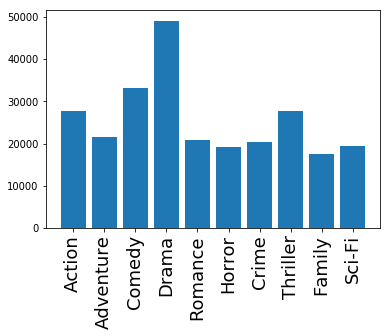

In [195]:
fig, ax = plt.subplots(1,1) 
ax.bar(range(len(count_dict_undersample_w_out_replacement.keys())), list(count_dict_undersample_w_out_replacement.values()))
ax.set_xticks(range(len(count_dict_undersample_w_out_replacement.keys())))
ax.set_xticklabels(list(count_dict_undersample_w_out_replacement.keys()), rotation='vertical', fontsize=18)

In [196]:
new_train.head()

,index,genres,plots,list_genres,list_genres_consol,USE_tokens,tokenized_words,USE_tokens_sentences,flattened_tokens,binarized_labels,USE_token_plot_embeddings,USE_tokens_sentences_padded,USE_token_sentence_embeddings,embedding
8416,9499,Action Adventure Comedy Drama Romance,Returning from five years of fighting in the c...,"[Action, Adventure, Comedy, Drama, Romance]","[Action, Adventure, Comedy, Drama, Romance]",returning from five years of fighting in the c...,"[[return, five, year, fight, crusade, robin, l...",[returning from five years of fighting in the ...,"[return, five, year, fight, crusade, robin, lo...","[1, 1, 1, 0, 1, 0, 0, 1, 0, 0]","[-0.06096358597278595, 0.004489850252866745, -...",[returning from five years of fighting in the ...,"[[0.01187861431390047, -0.0058340756222605705,...","[[75, 332, 15, 104, 5017, 2463, 28151, 14922, ..."
98848,112589,Comedy Fantasy Horror,Minature green monsters tear through the small...,"[Comedy, Fantasy, Horror]","[Comedy, Horror]",minature green monsters tear through the small...,"[[minature, green, monster, tear, small, town,...",[minature green monsters tear through the smal...,"[minature, green, monster, tear, small, town, ...","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[-0.04945174604654312, -0.045413605868816376, ...",[minature green monsters tear through the smal...,"[[-0.07718510180711746, 0.025827711448073387, ...","[[80000, 1420, 729, 1207, 114, 69, 11494, 57, ..."
118792,135343,Comedy Crime Mystery,In modern day London two rival gangs battle fo...,"[Comedy, Crime, Mystery]","[Comedy, Crime]",in modern day london two rival gangs battle fo...,"[[modern, day, london, two, rival, gang, battl...",[in modern day london two rival gangs battle f...,"[modern, day, london, two, rival, gang, battle...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0]","[-0.020149806514382362, -0.07221858203411102, ...",[in modern day london two rival gangs battle f...,"[[-0.025842778384685516, -0.07935530692338943,...","[[412, 28, 517, 19, 725, 214, 228, 9834, 793, ..."
71955,81982,Horror,Fuko Ando (Miori Takimoto) is a 24-years-old g...,[Horror],[Horror],fuko ando miori takimoto is a DG years old gra...,"[[fuko, ando, miori, takimoto, DG, year, old, ...",[fuko ando miori takimoto is a DG years old gr...,"[fuko, ando, miori, takimoto, DG, year, old, g...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[-0.060144055634737015, 0.002093486487865448, ...",[fuko ando miori takimoto is a DG years old gr...,"[[0.05729108303785324, 0.05751098319888115, -0...","[[66844, 26888, 80000, 80000, 5, 15, 26, 1289,..."
97498,111062,Fantasy Horror,An ex-reality star gives up the limelight to g...,"[Fantasy, Horror]",[Horror],an ex reality star gives up the limelight to g...,"[[ex, reality, star, give, limelight, give, pu...",[an ex reality star gives up the limelight to ...,"[ex, reality, star, give, limelight, give, pub...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[0.055379338562488556, 0.024881532415747643, 0...",[an ex reality star gives up the limelight to ...,"[[0.06213819608092308, -0.01658524014055729, 0...","[[285, 186, 168, 63, 10530, 63, 673, 498, 1037..."


In [24]:
new_train = new_train.reset_index()

In [92]:
new_train.index

Int64Index([181848, 148002, 219341, 171262,  86484, 127605, 122122,  65418,
             94522, 185318,
            ...
             27114, 100853,  35237, 216958, 209218, 187937,  54580, 183867,
            165722, 202363],
           dtype='int64', length=114730)

In [71]:
full_data.iloc[4450]

index                                                                         5005
genres                                                               Comedy Drama 
plots                            A coming-of-age comedy/drama set in Tunisia. T...
list_genres                                                        [Comedy, Drama]
list_genres_consol                                                 [Comedy, Drama]
USE_tokens                       a coming of age comedydrama set in tunisia. tw...
tokenized_words                  [[come, age, comedydrama, set, tunisia, .], [t...
USE_tokens_sentences             [a coming of age comedydrama set in tunisia., ...
flattened_tokens                 [come, age, comedydrama, set, tunisia, ., twel...
binarized_labels                                    [0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
USE_token_plot_embeddings        [-0.004395386204123497, -0.022659681737422943,...
USE_tokens_sentences_padded      [a coming of age comedydrama set in tunisia., ...
USE_

In [29]:
def indiv_class_scores_ensemble(y_true, y_pred, threshold):
    """y_pred is a dictionary of predictions while
        y_true is an array of predictions for the dev or test set"""
    
    list_of_predictions = []
    
    for preds in list(y_pred.values()):
        max_pred = np.array(preds.max(axis = 1)).reshape(-1,1)
    
        #Cant predict 0 for all classes - pick max val as label if all preds below threshold
        for i in range(len(max_pred)): 
            if max_pred[i] > threshold:
                max_pred[i] = threshold
            else:
                pass
        list_of_predictions.append(preds >= max_pred)
    
    voted_preds = sum(list_of_predictions)
    
    max_voted_preds = np.array(voted_preds.max(axis = 1)).reshape(-1,1)
    
    for i in range(len(max_voted_preds)): 
        if max_voted_preds[i] > 2.5:
            max_voted_preds[i] = 2.5
        else:
            pass

    
    y_pred = np.where(voted_preds >= max_voted_preds, 1, 0) #3 for yes is needed to predict a class
    
    for i in range(len(mlb.classes_)):
        score = precision_score(y_true[:,i], y_pred[:,i])
        print("The precision for {} is {}".format(mlb.classes_[i], score))
    
    for i in range(len(mlb.classes_)):  
        score = recall_score(y_true[:,i], y_pred[:,i])
        print("The recall for {} is {}".format(mlb.classes_[i], score))
        
    for i in range(len(mlb.classes_)): 
        score = f1_score(y_true[:,i], y_pred[:,i])
        print("The f1 for {} is {}".format(mlb.classes_[i], score))
    
    micro_precision = precision_score(y_true, y_pred, average = 'micro')
    weighted_macro_precision = precision_score(y_true, y_pred, average = 'weighted')
    micro_recall = recall_score(y_true, y_pred, average = 'micro')
    weighted_macro_recall = recall_score(y_true, y_pred, average = 'weighted')
    micro_f1 = f1_score(y_true, y_pred, average = 'micro')
    weighted_macro_f1 = f1_score(y_true, y_pred, average = 'weighted')
    print("The micro precision is", micro_precision)
    print("The weighted macro precision is", weighted_macro_precision)
    print("The micro recall is", micro_recall)
    print("The weighted macro recall is", weighted_macro_recall)
    print("The micro f1 is", micro_f1)
    print("The weighted macro f1 is", weighted_macro_f1)
    
    num_preds = y_pred.sum(axis = 1)
    avg_genre_per_pred = np.average(num_preds)
    median_genre_per_pred = np.median(num_preds)
    print("The average number of genres per movie is", avg_genre_per_pred)
    print("The median number of genres per movie is", median_genre_per_pred)
        
    #return list_of_predictions

In [33]:
sample_dfs = {}
for i in range(1,6):
    sample_dfs["model{}".format(i)] = undersample_w_out_replacement(train_set, count_dict_norm)
    
count_dict_nested = defaultdict(lambda: defaultdict(int))

def nested_dict_count(row, count_dict, model):
    for genre in row:
        count_dict_nested[model][genre] += 1

for i in range(1,6):
    count_val_series_2 = sample_dfs["model{}".format(i)]["list_genres_consol"].apply(lambda row: nested_dict_count(row, count_dict_nested, 
                                                                                     "model{}".format(i)))

Drama
Action
Romance
Horror
Comedy
Sci-Fi
Family
Adventure
Thriller
Crime
Drama
Action
Romance
Horror
Comedy
Sci-Fi
Family
Adventure
Thriller
Crime
Drama
Action
Romance
Horror
Comedy
Sci-Fi
Family
Adventure
Thriller
Crime
Drama
Action
Romance
Horror
Comedy
Sci-Fi
Family
Adventure
Thriller
Crime
Drama
Action
Romance
Horror
Comedy
Sci-Fi
Family
Adventure
Thriller
Crime


In [34]:
def train_HAN_model(sample, file, df):
    # Words level attention model
    word_input = Input(shape=(MAX_SENT_LENGTH,), dtype='float32')
    word_sequences = embedding_layer(word_input)
    word_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(word_sequences)
    word_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(word_lstm)
    word_att = AttentionWithContext()(word_dense)
    wordEncoder = Model(word_input, word_att)

    # Sentence level attention model
    sent_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH), dtype='float32')
    sent_encoder = TimeDistributed(wordEncoder)(sent_input)
    sent_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
    sent_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
    sent_att = Dropout(0.5)(AttentionWithContext()(sent_dense))
    preds = Dense(10, activation='sigmoid')(sent_att)
    model = Model(sent_input, preds)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])
    model.fit(sample, np.stack(df["binarized_labels"]), epochs = 10, batch_size = 500)
    print("Predicting")
    predict = model.predict(x_dev)
    model.save(file)
    return predict

def train_HAN_samples(df_dict):

    model_num = 1
    preds_group = {}

    for i in list(df_dict.values()):
        print("Training model " + str(model_num))
        x_train = np.stack(i["embedding"])
        preds_group["preds_{}".format(model_num)] = train_HAN_model(x_train,
                                                               "./local/HAN_300dim_500batch_dropout_sample_{}.h5".format(model_num),
                                                                         i)
        model_num += 1
        
    return preds_group

In [44]:
preds_dict = train_HAN_samples(sample_dfs)

Training model 1
Epoch 1/10
114730/114730 [==============================] - 223s 2ms/step - loss: 0.4272 - acc: 0.8068
Epoch 2/10
114730/114730 [==============================] - 210s 2ms/step - loss: 0.3807 - acc: 0.8283
Epoch 3/10
114730/114730 [==============================] - 210s 2ms/step - loss: 0.3643 - acc: 0.8364
Epoch 4/10
114730/114730 [==============================] - 214s 2ms/step - loss: 0.3481 - acc: 0.8444
Epoch 5/10
114730/114730 [==============================] - 214s 2ms/step - loss: 0.3304 - acc: 0.8536
Epoch 6/10
114730/114730 [==============================] - 215s 2ms/step - loss: 0.3104 - acc: 0.8638
Epoch 7/10
114730/114730 [==============================] - 213s 2ms/step - loss: 0.2893 - acc: 0.8742
Epoch 8/10
114730/114730 [==============================] - 211s 2ms/step - loss: 0.2687 - acc: 0.8846
Epoch 9/10
114730/114730 [==============================] - 209s 2ms/step - loss: 0.2479 - acc: 0.8949
Epoch 10/10
114730/114730 [=============================

In [50]:
indiv_class_scores_ensemble(y_dev, preds_dict, 0.5)

The precision for Action is 0.4438549955791335
The precision for Adventure is 0.3723916532905297
The precision for Comedy is 0.6248620816476645
The precision for Crime is 0.3698461538461538
The precision for Drama is 0.6823243860651057
The precision for Family is 0.34130320546505516
The precision for Horror is 0.48442422121106055
The precision for Romance is 0.3291193486179559
The precision for Sci-Fi is 0.48560273304050755
The precision for Thriller is 0.3728498372849837
The recall for Action is 0.6055488540410132
The recall for Adventure is 0.5161290322580645
The recall for Comedy is 0.7210355071438675
The recall for Crime is 0.6448497854077253
The recall for Drama is 0.8291117279666897
The recall for Family is 0.6197519083969466
The recall for Horror is 0.7011144883485309
The recall for Romance is 0.5634629493763756
The recall for Sci-Fi is 0.6718433490884538
The recall for Thriller is 0.5681898689337584
The f1 for Action is 0.5122448979591837
The f1 for Adventure is 0.4326340326340

In [30]:
def auc_pr_ensemble(y_true, y_pred):
    y_pred = np.mean(list(y_pred.values()), axis = 0)
    scores = []
    for i in range(len(mlb.classes_)):
        p, r, d = precision_recall_curve(y_true[:,i], y_pred[:,i])
        score = auc(r,p)
        scores.append(score)
        print("The AUC for {} is {}".format(mlb.classes_[i], score))
    macro_score = np.mean(scores)
    y_true_raveled = np.ravel(y_true)
    y_pred_raveled = np.ravel(y_pred)
    p, r, d = precision_recall_curve(y_true_raveled, y_pred_raveled)
    micro_score = auc(r,p)
    print("The micro-avg AUC is {}".format(micro_score))
    print("The macro-avg AUC is {}".format(macro_score))

In [53]:
auc_pr_ensemble(y_dev, preds_dict)

The AUC for Action is 0.5240888174540498
The AUC for Adventure is 0.42422789668860206
The AUC for Comedy is 0.7383277141813722
The AUC for Crime is 0.4608260551012592
The AUC for Drama is 0.7912182634178366
The AUC for Family is 0.4849406043901256
The AUC for Horror is 0.6142909130155302
The AUC for Romance is 0.36248892562381646
The AUC for Sci-Fi is 0.6128518544237195
The AUC for Thriller is 0.4185164720456757
The micro-avg AUC is 0.624944344146521
The macro-avg AUC is 0.5431777516341987


In [49]:
full_data["embedding"][0]

[[7990, 3881, 3273, 1578, 8, 41, 38, 73, 12, 7, 2059, 264, 1, 0, 0],
 [405, 746, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [609, 1528, 21241, 1703, 177, 65, 609, 1528, 1, 0, 0, 0, 0, 0, 0],
 [73, 12, 13, 3703, 1000, 5204, 5, 75, 2059, 264, 304, 75, 177, 665, 4090],
 [1703, 897, 246, 2278, 2059, 264, 1528, 21241, 609, 1, 0, 0, 0, 0, 0]]

In [47]:
full_data["USE_token_sentence_embeddings"].shape
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix], 
                            input_length=MAX_SENT_LENGTH, 
                            trainable=False)

(224303,)

In [28]:
def train_USE_HAN_model(sample, file, df):
    # Sentence level attention model)
    sent_input = Input(shape=(MAX_SENTS, 512), dtype='float32')
    sent_sequences = Lambda(lambda x:x,output_shape=(MAX_SENTS, 512))(sent_input) #UniversalEmbedding,output_shape=(embed_size,))(input_text)
    sent_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(sent_sequences)
    sent_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
    sent_att = Dropout(0.5)(AttentionWithContext()(sent_dense))
    preds = Dense(10, activation='sigmoid')(sent_att)
    model = Model(sent_input, preds)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])
    model.fit(sample, np.stack(df["binarized_labels"]), epochs = 10, batch_size = 500)
    print("Predicting")
    predict = model.predict(x_dev)
    model.save(file)
    return predict

In [29]:
def train_USE_HAN_samples(df_dict):

    model_num = 1
    preds_group = {}

    for i in list(df_dict.values()):
        print("Training model " + str(model_num))
        x_train = np.stack(i["USE_token_sentence_embeddings"])
        preds_group["preds_{}".format(model_num)] = train_USE_HAN_model(x_train,
                                                               "./local/USE_HAN_300dim_500batch_dropout_sample_{}.h5".format(model_num),
                                                                         i)
        model_num += 1
        
    return preds_group

In [86]:
USE_preds_dict = train_USE_HAN_samples(sample_dfs)

Training model 1
Epoch 1/10
114730/114730 [==============================] - 33s 284us/step - loss: 0.4326 - acc: 0.8041
Epoch 2/10
114730/114730 [==============================] - 29s 256us/step - loss: 0.3895 - acc: 0.8226
Epoch 3/10
114730/114730 [==============================] - 29s 252us/step - loss: 0.3828 - acc: 0.8262
Epoch 4/10
114730/114730 [==============================] - 29s 253us/step - loss: 0.3787 - acc: 0.8282
Epoch 5/10
114730/114730 [==============================] - 29s 252us/step - loss: 0.3752 - acc: 0.8298
Epoch 6/10
114730/114730 [==============================] - 29s 254us/step - loss: 0.3722 - acc: 0.8316
Epoch 7/10
114730/114730 [==============================] - 29s 254us/step - loss: 0.3694 - acc: 0.8327
Epoch 8/10
114730/114730 [==============================] - 29s 252us/step - loss: 0.3666 - acc: 0.8341
Epoch 9/10
114730/114730 [==============================] - 29s 253us/step - loss: 0.3639 - acc: 0.8356
Epoch 10/10
114730/114730 [====================

In [52]:
#import tensorflow as tf

KeyError: 0

In [36]:
x_dev = np.stack(dev_set["USE_token_plot_embeddings"])
y_dev = np.stack(dev_set["binarized_labels"])

In [87]:
auc_pr_ensemble(y_dev, USE_preds_dict)

The AUC for Action is 0.5462559639924255
The AUC for Adventure is 0.4300937378035205
The AUC for Comedy is 0.7174280736870873
The AUC for Crime is 0.4299795274999502
The AUC for Drama is 0.7950425362264104
The AUC for Family is 0.48230767353328247
The AUC for Horror is 0.6086722586490639
The AUC for Romance is 0.3841523903354247
The AUC for Sci-Fi is 0.632598135728725
The AUC for Thriller is 0.41421208365987094
The micro-avg AUC is 0.6224622140237992
The macro-avg AUC is 0.5440742381115761


In [89]:
indiv_class_scores_ensemble(y_dev, USE_preds_dict, 0.5)

The precision for Action is 0.5166051660516605
The precision for Adventure is 0.4343867166577397
The precision for Comedy is 0.691073219658977
The precision for Crime is 0.4192521877486078
The precision for Drama is 0.7143422197610948
The precision for Family is 0.4357588357588358
The precision for Horror is 0.5417028670721112
The precision for Romance is 0.3828102082722206
The precision for Sci-Fi is 0.5800508259212198
The precision for Thriller is 0.4208765473402476
The recall for Action is 0.5629272215520708
The recall for Adventure is 0.4510567296996663
The recall for Comedy is 0.5848069033809591
The recall for Crime is 0.5654506437768241
The recall for Drama is 0.7833102012491325
The recall for Family is 0.5
The recall for Horror is 0.6317122593718338
The recall for Romance is 0.4787234042553192
The recall for Sci-Fi is 0.6164753544902093
The recall for Thriller is 0.44562522139567834
The f1 for Action is 0.5387723686742352
The f1 for Adventure is 0.44256480218281036
The f1 for Co

In [30]:
def train_USE_HAN_fulldata(data):
    model_num = 1
    preds_group = {}

    print("Training model " + str(model_num))
    x_train = np.stack(data["USE_token_sentence_embeddings"])
    preds_group["preds_{}".format(model_num)] = train_USE_HAN_model(x_train,
                                                               "./local/USE_HAN_300dim_500batch_dropout_sample_{}.h5".format(model_num),
                                                                         i)
    model_num += 1
        
    return preds_group

In [95]:
fulldata_pred = train_USE_HAN_model(np.stack(train_set["USE_token_sentence_embeddings"]), "./local/USE_HAN_300dim_500batch_dropout_fulldata.h5",train_set)

Epoch 1/10
179666/179666 [==============================] - 52s 290us/step - loss: 0.3278 - acc: 0.8662
Epoch 2/10
179666/179666 [==============================] - 47s 263us/step - loss: 0.2937 - acc: 0.8767
Epoch 3/10
179666/179666 [==============================] - 48s 265us/step - loss: 0.2890 - acc: 0.8787
Epoch 4/10
179666/179666 [==============================] - 47s 262us/step - loss: 0.2860 - acc: 0.8801
Epoch 5/10
179666/179666 [==============================] - 46s 259us/step - loss: 0.2835 - acc: 0.8811
Epoch 6/10
179666/179666 [==============================] - 48s 269us/step - loss: 0.2816 - acc: 0.8819
Epoch 7/10
179666/179666 [==============================] - 47s 260us/step - loss: 0.2794 - acc: 0.8827
Epoch 8/10
179666/179666 [==============================] - 47s 262us/step - loss: 0.2780 - acc: 0.8834
Epoch 9/10
179666/179666 [==============================] - 48s 270us/step - loss: 0.2764 - acc: 0.8840
Epoch 10/10
179666/179666 [==============================] - 48s

In [96]:
auc_pr(y_dev, fulldata_pred)

The AUC for Action is 0.5527689577437199
The AUC for Adventure is 0.4422147363418738
The AUC for Comedy is 0.7305358593913303
The AUC for Crime is 0.44035213018055847
The AUC for Drama is 0.8085340420157743
The AUC for Family is 0.4966782864470115
The AUC for Horror is 0.6113529062565832
The AUC for Romance is 0.3995672757487425
The AUC for Sci-Fi is 0.6287086303480689
The AUC for Thriller is 0.4170264439103551
The micro-avg AUC is 0.6661143960200353
The macro-avg AUC is 0.5527739268384018


In [98]:
y_pred = fulldata_pred >= 0.5
micro_precision = precision_score(y_dev, y_pred, average = 'micro')
weighted_macro_precision = precision_score(y_dev, y_pred, average = 'weighted')
micro_recall = recall_score(y_dev, y_pred, average = 'micro')
weighted_macro_recall = recall_score(y_dev, y_pred, average = 'weighted')
micro_f1 = f1_score(y_dev, y_pred, average = 'micro')
weighted_macro_f1 = f1_score(y_dev, y_pred, average = 'weighted')

In [99]:
print("The micro precision is", micro_precision)
print("The weighted macro precision is", weighted_macro_precision)
print("The micro recall is", micro_recall)
print("The weighted macro recall is", weighted_macro_recall)
print("The micro f1 is", micro_f1)
print("The weighted macro f1 is", weighted_macro_f1)

The micro precision is 0.7024703317994672
The weighted macro precision is 0.6807239201560332
The micro recall is 0.4854934999721029
The weighted macro recall is 0.4854934999721029
The micro f1 is 0.5741669416034312
The weighted macro f1 is 0.5378685849368693


In [31]:
def train_USE_FC_model(sample, file, df):
    sent_input = Input(shape=(512,), dtype='float32')
    sent_sequences = Lambda(lambda x:x,output_shape=(512,))(sent_input) 
    sent_dense = Dense(200, kernel_regularizer=l2_reg)(sent_sequences)
    post_drop = Dropout(0.5)(sent_dense)
    preds = Dense(10, activation='sigmoid')(post_drop)
    model = Model(sent_input, preds)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])
    model.fit(sample, np.stack(df["binarized_labels"]), epochs = 10, batch_size = 500)
    print("Predicting")
    predict = model.predict(x_dev)
    model.save(file)
    return predict

In [139]:
fulldata_USE_FC_pred = train_USE_FC_model(np.stack(train_set["USE_token_plot_embeddings"]), "./local/USE_FC_500batch_dropout_fulldata.h5",train_set)

Epoch 1/10
179666/179666 [==============================] - 6s 36us/step - loss: 0.3288 - acc: 0.8661
Epoch 2/10
179666/179666 [==============================] - 4s 21us/step - loss: 0.2972 - acc: 0.8749
Epoch 3/10
179666/179666 [==============================] - 4s 21us/step - loss: 0.2950 - acc: 0.8760
Epoch 4/10
179666/179666 [==============================] - 4s 21us/step - loss: 0.2938 - acc: 0.8763
Epoch 5/10
179666/179666 [==============================] - 4s 21us/step - loss: 0.2931 - acc: 0.8768
Epoch 6/10
179666/179666 [==============================] - 4s 22us/step - loss: 0.2923 - acc: 0.8770
Epoch 7/10
179666/179666 [==============================] - 4s 22us/step - loss: 0.2920 - acc: 0.8772
Epoch 8/10
179666/179666 [==============================] - 4s 22us/step - loss: 0.2914 - acc: 0.8774
Epoch 9/10
179666/179666 [==============================] - 4s 22us/step - loss: 0.2909 - acc: 0.8777
Epoch 10/10
179666/179666 [==============================] - 4s 21us/step - loss: 

In [140]:
auc_pr(y_dev, fulldata_USE_FC_pred)

The AUC for Action is 0.5453001761711098
The AUC for Adventure is 0.3957226378873043
The AUC for Comedy is 0.6974327702002612
The AUC for Crime is 0.41839870432787946
The AUC for Drama is 0.7841624367518782
The AUC for Family is 0.45220466134752396
The AUC for Horror is 0.5607895843008089
The AUC for Romance is 0.38483609153557025
The AUC for Sci-Fi is 0.5991009093403481
The AUC for Thriller is 0.3869944846698701
The micro-avg AUC is 0.6390774992517999
The macro-avg AUC is 0.5224942456532553


In [141]:
y_pred = fulldata_USE_FC_pred >= 0.5
micro_precision = precision_score(y_dev, y_pred, average = 'micro')
weighted_macro_precision = precision_score(y_dev, y_pred, average = 'weighted')
micro_recall = recall_score(y_dev, y_pred, average = 'micro')
weighted_macro_recall = recall_score(y_dev, y_pred, average = 'weighted')
micro_f1 = f1_score(y_dev, y_pred, average = 'micro')
weighted_macro_f1 = f1_score(y_dev, y_pred, average = 'weighted')
print("The micro precision is", micro_precision)
print("The weighted macro precision is", weighted_macro_precision)
print("The micro recall is", micro_recall)
print("The weighted macro recall is", weighted_macro_recall)
print("The micro f1 is", micro_f1)
print("The weighted macro f1 is", weighted_macro_f1)

The micro precision is 0.6964494732735076
The weighted macro precision is 0.6747163963318376
The micro recall is 0.44816715951570607
The weighted macro recall is 0.44816715951570607
The micro f1 is 0.5453804762955545
The weighted macro f1 is 0.49958371667356677


In [32]:
def train_USE_FC_samples(df_dict):

    model_num = 1
    preds_group = {}

    for i in list(df_dict.values()):
        print("Training model " + str(model_num))
        x_train = np.stack(i["USE_token_plot_embeddings"])
        preds_group["preds_{}".format(model_num)] = train_USE_FC_model(x_train,
                                                               "./local/USE_fulldata_300dim_500batch_dropout_sample_{}.h5".format(model_num),
                                                                         i)
        model_num += 1
        
    return preds_group

In [ ]:
USE_FC_samples_preds_dict = train_USE_FC_samples(sample_dfs)

Training model 1
Epoch 1/10
114730/114730 [==============================] - 5s 45us/step - loss: 0.4340 - acc: 0.8034
Epoch 2/10
114730/114730 [==============================] - 3s 22us/step - loss: 0.3942 - acc: 0.8207
Epoch 3/10
114730/114730 [==============================] - 3s 22us/step - loss: 0.3912 - acc: 0.8223
Epoch 4/10
114730/114730 [==============================] - 3s 22us/step - loss: 0.3895 - acc: 0.8233
Epoch 5/10
114730/114730 [==============================] - 3s 23us/step - loss: 0.3883 - acc: 0.8240
Epoch 6/10
114730/114730 [==============================] - 3s 22us/step - loss: 0.3877 - acc: 0.8242
Epoch 7/10
114730/114730 [==============================] - 3s 22us/step - loss: 0.3868 - acc: 0.8247
Epoch 8/10
114730/114730 [==============================] - 3s 22us/step - loss: 0.3863 - acc: 0.8250
Epoch 9/10
114730/114730 [==============================] - 3s 22us/step - loss: 0.3857 - acc: 0.8252
Epoch 10/10
114730/114730 [==============================] - 3s 2

In [ ]:
auc_pr_ensemble(y_dev, USE_FC_samples_preds_dict)

In [ ]:
indiv_class_scores_ensemble(y_dev, USE_FC_samples_preds_dict, 0.5)

In [58]:
preds[0]

array([0.01384354, 0.02507908, 0.8756969 , 0.01674592, 0.10674362,
       0.05267188, 0.02080834, 0.09573961, 0.00467977, 0.02327636],
      dtype=float32)

In [43]:
preds = model.predict(x_dev)

In [33]:
def comparePred(pred, actual, dev_set, index):
    genres = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Horror', 'Romance', 'Sci-Fi', 'Thriller']
    print("Predicted:")
    genreSelected = False
    for i in range(10):
        if(pred[index][i] >= 0.5):
            print(genres[i])
            print(pred[index][i])
            genreSelected = True
    if genreSelected ==False:
        print(genres[np.argmax(pred[index])])
        print(pred[index][i])

    print()
    print("Actual:")
    for i in range(10):
        if actual[index][i] == 1:
            print(genres[i])
    print()
    print("Plot:")
    print(dev_set.iloc[index]["plots"])
    
    print()
    print("Tokens")
    #print(dev_set.iloc[index]["USE_tokens_sentences_padded"])
    print(dev_set.iloc[index]["tokenized_words"])
            

In [45]:
comparePred(preds, y_dev, dev_set, 0)

Predicted:
Comedy
0.8756969

Actual:
Comedy

Plot:
Follows Manager Klaus Schlegle and the door-to-door salesmen of At Your Door Service Enterprises (A.Y.D.S.E.). New salesman Bryan Cooper, socially confused Cynthia Patterson, and fitness aficionado Ed Phuket are the sales team. Under the direction of their overly enthusiastic boss Klaus, and with sales routes mapped by bitter receptionist Mildred Mortimer, they go door to door to sell a variety of wacky products. 

Tokens
['follows manager klaus schlegle and the door to door salesmen of at your door service enterprises aydse.', 'new salesman bryan cooper socially confused cynthia patterson and fitness aficionado ed phuket are the sales team.', 'under the direction of their overly enthusiastic boss klaus and with sales routes mapped by bitter receptionist mildred mortimer they go door to door to sell a variety of wacky products.', 'EMPTY', 'EMPTY']


In [46]:
comparePred(preds, y_dev, dev_set, 1)

Predicted:
Drama
0.57791966

Actual:
Horror
Sci-Fi

Plot:
Theodora, Jody and Carol, collectively The Violas, are on tour when their van breaks down in a small southern beach town. The local police are investigating a mass of mysterious debris on the beach and the disappearance of a little girl's parents after she's found walking the beach in a state of shock. Scientist John Patterson is called in to help investigate. Both John and local mechanic Hector Garcia fall for Violas lead singer Theodora, but she seems to have no interest in them, possibly because of a mysterious past. Hector convinces the girls to stay in town when he offers to repair their van in exchange for playing his party, but the mysterious creature is still on the loose. 

Tokens
['theodora jody and carol collectively the violas are on tour when their van breaks down in a small southern beach town.', "the local police are investigating a mass of mysterious debris on the beach and the disappearance of a little girl's pa

In [47]:
comparePred(preds, y_dev, dev_set, 2)

Predicted:
Action
0.5810109
Drama
0.5009569

Actual:
Action
Thriller

Plot:
Gabriel is promised his freedom in return for his service in a rescue operation to save a missing British operative. When Gabriel is captured and taken to the compound where his target and several others are being held, he must devise a plan to take on the entire North Korean military installation and get everyone to safety. 

Tokens
['gabriel is promised his freedom in return for his service in a rescue operation to save a missing british operative.', 'when gabriel is captured and taken to the compound where his target and several others are being held he must devise a plan to take on the entire north korean military installation and get everyone to safety.', 'EMPTY', 'EMPTY', 'EMPTY']


In [83]:
comparePred(preds, y_dev, dev_set, 3)

Predicted:
Drama
0.914151

Actual:
Drama

Plot:
Moloya gets a shock of her life when her newly married husband Pranjal suddenly declares that his life ambition is to serve in the rural areas in Assam - something that was not known to her although they have known each other for many years and they have studied medicine together. The clash begins before they could start their home. 

Tokens
['moloya gets a shock of her life when her newly married husband pranjal suddenly declares that his life ambition is to serve in the rural areas in assam something that was not known to her although they have known each other for many years and they have studied medicine together.', 'the clash begins before they could start their home.', 'EMPTY', 'EMPTY', 'EMPTY']


In [84]:
comparePred(preds, y_dev, dev_set, 4)

Predicted:
Drama
0.65094334

Actual:
Drama

Plot:
What happens when a natural disaster hits a rural town of only 400 residents? In less than 6 hours Hurricane Irene destroyed all roads in and out of Pittsfield Vermont and the town became an isolated island with no power, phone service or medical facilities. In the face of chaos, would this small community fall apart or come together? 

Tokens
['what happens when a natural disaster hits a rural town of only DG residents?', 'in less than DG hours hurricane irene destroyed all roads in and out of pittsfield vermont and the town became an isolated island with no power phone service or medical facilities.', 'in the face of chaos would this small community fall apart or come together?', 'EMPTY', 'EMPTY']


In [85]:
comparePred(preds, y_dev, dev_set, 5)

Predicted:
Comedy
0.62210685

Actual:
Drama
Romance

Plot:
Humans are known to be curious beasts. There are times when we all had fantasies that were so odd that we were afraid people would think we're crazy! But the women in this film have waited too long to get what they need. Veronica Vain is a newlywed, and her new mother-in-law Kendra James hears from her best friend Kendra Lust just how to get her into trouble. When Kendra's invited over for dinner she takes the real chance that she and Veronica might almost be caught in the act. Adriana Chechik is just like any other teen. She waits until her parents are out and then rushes to the family computer to look up all the weird and wacky fantasies running through her mind. Little does she know that her seemingly typical stepmom Veronica Avluv is actually an expert. Talking to her is like finding the holy grail when it comes to her biggest fantasy, squirting! 

Tokens
['humans are known to be curious beasts.', "there are times when we a

In [92]:
comparePred(preds, y_dev, dev_set, 6)

Predicted:
Drama
0.12039418

Actual:
Drama

Plot:
A jaded, wealthy couple watch a blue movie in their castle home along with her adult son. The son is testy, so they go into town and watch a circus-like thrill ride. The daredevil woman in the show looks exactly like one of the women in the movie, so the man invites her to join them for a nightcap. Tensions among the family seem to rise. She stays overnight, and during her 24 hours in the castle, each of its three residents involves her in a fantasy. She, in turn, keeps asking, "Who has the gun?" Will there be violence before it's over? 

Tokens
['a jaded wealthy couple watch a blue movie in their castle home along with her adult son.', 'the son is testy so they go into town and watch a circus like thrill ride.', 'the daredevil woman in the show looks exactly like one of the women in the movie so the man invites her to join them for a nightcap.', 'tensions among the genre seem to rise.', 'she stays overnight and during her DG hours in t

In [93]:
comparePred(preds, y_dev, dev_set, 7)

Predicted:
Adventure
0.56983435
Drama
0.5374316

Actual:
Action
Adventure

Plot:
Adventure does not always need to start in a country ending with Stan. Sometimes it can be found subtly, just around the corner. In February 2011, pro skiers Kaj Zackrisson and Mike Douglas spent two weeks chasing powder across Switzerland by train. Trains started carrying skiers up and across the Alps more than 100 years ago. In a fast world, the train provides a refreshing experience - one that, will hopefully, never be lost. 

Tokens
['genre does not always need to start in a country ending with stan.', 'sometimes it can be found subtly just around the corner.', 'in february DG pro skiers kaj zackrisson and mike douglas spent two weeks chasing powder across switzerland by train.', 'trains started carrying skiers up and across the alps more than DG years ago.', 'in a fast world the train provides a refreshing experience one that will hopefully never be lost.']


In [34]:
def createConfusionMatrix(pred, actual, dev_set, alwaysPredict = False):
    genres = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Horror', 'Romance', 'Sci-Fi', 'Thriller']
    a = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '01', '02', '03', '04', '05','06',
                 '07', '08', '09', '12' ,'13', '14', '15', '16', '17', '18', '19', '23', '24', '25', '26', '27',
                 '28','29','34', '35','36','37','38','39','45','46','47','48','49','56','57','58','59','67',
                 '68','69','78','79','89','99'])
    matrix = np.zeros((len(a),len(a)))
    for index in range(len(pred)):
        genreSelected = False
        predictions = np.zeros((10))
        #print("hi")
        predictedIndices = ""
        for i in range(10):
            if(pred[index][i] >= 0.5):
                predictions[i] = 1
                genreSelected = True
                predictedIndices += str(i)
                #print(predictedIndices)
        if alwaysPredict and genreSelected ==False:
            predictions[np.argmax(pred[index])] = 1
            predictedIndices = str(np.argmax(pred[index]))
            genreSelected = True
        if genreSelected == False:
            predictedIndices = '99'
        
        actualIndices = ""
        for k in range(10):
            if actual[index][k] == 1:
                actualIndices += str(k)
                #print(actualIndices)
        if(len(predictedIndices)<3 and len(actualIndices)<3):
            #print(predictedIndices)
            #print(actualIndices)
            column = np.argwhere(a==predictedIndices)[0][0]
            row = np.argwhere(a==actualIndices)[0][0]
            matrix[row,column] = matrix[row,column] + 1
    return matrix

In [171]:
full_data.head()

,index,genres,plots,list_genres,list_genres_consol,USE_tokens,tokenized_words,USE_tokens_sentences,flattened_tokens,binarized_labels,USE_token_plot_embeddings,USE_tokens_sentences_padded,USE_token_sentence_embeddings,embedding
0,0,Comedy,A stranded theatrical troupe manages to get ba...,[Comedy],[Comedy],a stranded theatrical troupe manages to get ba...,"[[stranded, theatrical, troupe, manages, get, ...",[a stranded theatrical troupe manages to get b...,"[stranded, theatrical, troupe, manages, get, b...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0.06496927887201309, 0.02937605045735836, 0.0...",[a stranded theatrical troupe manages to get b...,"[[0.04774859547615051, 0.03576108068227768, -0...","[[7990, 3881, 3273, 1578, 8, 41, 38, 73, 12, 7..."
1,1,Drama,While waiting at the bus stop for the woman he...,[Drama],[Drama],while waiting at the bus stop for the woman he...,"[[wait, bus, stop, woman, intend, marry, jay, ...",[while waiting at the bus stop for the woman h...,"[wait, bus, stop, woman, intend, marry, jay, d...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0.03805602714419365, 0.05806170403957367, -0....",[while waiting at the bus stop for the woman h...,"[[0.030491432175040245, 0.00019499639165587723...","[[377, 1364, 179, 25, 1341, 142, 2062, 1510, 4..."
2,3,Drama,Policeman Lasse rehabilitates young prisoners ...,[Drama],[Drama],policeman lasse rehabilitates young prisoners ...,"[[policeman, lasse, rehabilitate, young, priso...",[policeman lasse rehabilitates young prisoners...,"[policeman, lasse, rehabilitate, young, prison...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[-0.031366996467113495, 0.0004756059206556529,...",[policeman lasse rehabilitates young prisoners...,"[[-0.02940049022436142, -0.06734874099493027, ...","[[1291, 13109, 9460, 10, 935, 11, 903, 399, 31..."
3,4,Adventure Animation Comedy,Patricia and Isobelle O'Sullivan arrives at th...,"[Adventure, Animation, Comedy]","[Adventure, Comedy]",patricia and isobelle o'sullivan arrives at th...,"[[patricia, isobelle, o'sullivan, arrive, st.,...",[patricia and isobelle o'sullivan arrives at t...,"[patricia, isobelle, o'sullivan, arrive, st., ...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0]","[-0.06273579597473145, 0.042697515338659286, -...",[patricia and isobelle o'sullivan arrives at t...,"[[0.014844884164631367, 0.0431971549987793, 0....","[[4199, 58589, 23221, 213, 2084, 1632, 279, 30..."
4,5,Drama,Anna Zaccheo is a beautiful young woman from a...,[Drama],[Drama],anna zaccheo is a beautiful young woman from a...,"[[anna, zaccheo, beautiful, young, woman, work...",[anna zaccheo is a beautiful young woman from ...,"[anna, zaccheo, beautiful, young, woman, work,...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[-0.03793998435139656, 0.03065059520304203, -0...",[anna zaccheo is a beautiful young woman from ...,"[[-0.003618143266066909, 0.0034949216060340405...","[[838, 80000, 162, 10, 25, 34, 358, 17246, 4, ..."


In [88]:
a = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '01', '02', '03', '04', '05','06',
                 '07', '08', '09', '12' ,'13', '14', '15', '16', '17', '18', '19', '23', '24', '25', '26', '27',
                 '28','29','34', '35','36','37','38','39','45','46','47','48','49','56','57','58','59','67',
                 '68','69','78','79','89'])

In [129]:
matrix = createConfusionMatrix(preds, y_dev, dev_set, alwaysPredict = False)

In [109]:
np.rint(matrix)

array([[ 114.,    8.,   37., ...,    0.,    0.,    0.],
       [  22.,   87.,   68., ...,    0.,    0.,    0.],
       [  22.,    8., 1925., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    1., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   1.,    0.,    2., ...,    0.,    0.,    1.]])

In [101]:
np.set_printoptions(suppress=True)

In [115]:
np.set_printoptions(threshold=10000)


In [130]:
matrix.shape

(56, 56)

In [131]:
matrix[0:10,0:10]

array([[  96.,    4.,   23.,    0.,  122.,    0.,    3.,    0.,   13.,
           1.],
       [  13.,   56.,   41.,    0.,  110.,    3.,    6.,    0.,   11.,
           1.],
       [  13.,    4., 1751.,   10.,  695.,    6.,   32.,    2.,   10.,
           1.],
       [   5.,    0.,   13.,   11.,  105.,    0.,    2.,    0.,    0.,
           5.],
       [  14.,   10.,  375.,    4., 4294.,   15.,   23.,    0.,   11.,
           4.],
       [   1.,    8.,   86.,    0.,  224.,   46.,    3.,    0.,    4.,
           0.],
       [   6.,    2.,   75.,    3.,  156.,    1.,  197.,    0.,    5.,
           9.],
       [   1.,    0.,   50.,    1.,  150.,    1.,    0.,    0.,    0.,
           0.],
       [   5.,    0.,   18.,    0.,   64.,    0.,    7.,    0.,   93.,
           4.],
       [   4.,    1.,   36.,    6.,  235.,    0.,   19.,    0.,    4.,
          19.]])

In [31]:
x_test = np.stack(test_set["USE_token_sentence_embeddings"])

In [32]:
model1 = load_model('./local/USE_HAN_300dim_500batch_dropout_sample_1.h5', custom_objects={'AttentionWithContext': AttentionWithContext})
model2 = load_model('./local/USE_HAN_300dim_500batch_dropout_sample_2.h5', custom_objects={'AttentionWithContext': AttentionWithContext})
model3 = load_model('./local/USE_HAN_300dim_500batch_dropout_sample_3.h5', custom_objects={'AttentionWithContext': AttentionWithContext})
model4 = load_model('./local/USE_HAN_300dim_500batch_dropout_sample_4.h5', custom_objects={'AttentionWithContext': AttentionWithContext})
model5 = load_model('./local/USE_HAN_300dim_500batch_dropout_sample_5.h5', custom_objects={'AttentionWithContext': AttentionWithContext})

In [33]:
pred1 = model1.predict(x_test)
pred2 = model2.predict(x_test)
pred3 = model3.predict(x_test)
pred4 = model4.predict(x_test)
pred5 = model5.predict(x_test)

array([0.09668459, 0.14181063, 1.5505122 , 0.09284881, 0.37828785,
       0.09042616, 0.12577462, 0.49958137, 0.0239905 , 0.11721288],
      dtype=float32)

In [35]:
def createEnsembleConfusionMatrix(pred1, pred2, pred3, pred4, pred5, actual, dev_set, alwaysPredict = False):
    genres = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Horror', 'Romance', 'Sci-Fi', 'Thriller']
    a = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '01', '02', '03', '04', '05','06',
                 '07', '08', '09', '12' ,'13', '14', '15', '16', '17', '18', '19', '23', '24', '25', '26', '27',
                 '28','29','34', '35','36','37','38','39','45','46','47','48','49','56','57','58','59','67',
                 '68','69','78','79','89','99'])
    d={}
    matrix = np.zeros((len(a),len(a)))
    pred = pred1+pred2+pred3+pred4+pred5
    good_plot =0
    good_num_sent_total =0
    good_sent_len_total =0
    good_truncated = 0
    bad_plot =0
    bad_num_sent_total =0
    bad_sent_len_total =0
    bad_truncated = 0
    for index in range(len(pred)):
        genreSelected = False
        predictions = np.zeros((10))
        #print("hi")
        predictedIndices = ""
        for i in range(10):
            if(pred[index][i] >= 2.5):
                predictions[i] = 1
                genreSelected = True
                predictedIndices += str(i)
                #print(predictedIndices)
        if alwaysPredict and genreSelected ==False:
            predictions[np.argmax(pred[index])] = 1
            predictedIndices = str(np.argmax(pred[index]))
            genreSelected = True
        if genreSelected == False:
            predictedIndices = '99'
        
        actualIndices = ""
        for k in range(10):
            if actual[index][k] == 1:
                actualIndices += str(k)
                #print(actualIndices)
        if(len(predictedIndices)<3 and len(actualIndices)<3):
            #print(predictedIndices)
            #print(actualIndices)
            column = np.argwhere(a==predictedIndices)[0][0]
            row = np.argwhere(a==actualIndices)[0][0]
            matrix[row,column] = matrix[row,column] + 1
            
        tokenized_words = dev_set.iloc[index]["tokenized_words"]
        num_sent = len(tokenized_words)
        sent_len = 0
        for sent in range(num_sent):
            sent_len += len(tokenized_words[sent])
        avg_sent_len = sent_len/num_sent
        if(num_sent>5):
            truncated_sent = True
        else:
            truncated_sent = False
        if predictedIndices == actualIndices:
            good_plot +=1
            good_num_sent_total += num_sent
            good_sent_len_total += avg_sent_len
            if truncated_sent:
                good_truncated +=1
        else:
            bad_plot +=1
            bad_num_sent_total += num_sent
            bad_sent_len_total += avg_sent_len
            if truncated_sent:
                bad_truncated +=1
        if(len(predictedIndices)<2 and len(actualIndices)<2):
            if actualIndices not in d:
                d[actualIndices] = [1, num_sent,avg_sent_len]
            else:
                d[actualIndices][0] += 1
                d[actualIndices][1] += num_sent
                d[actualIndices][2] += avg_sent_len
                
    for key, value in d.items():
        print(genres[int(key)])
        print("Avg sent number")
        print(value[1]/value[0])
        print("Avg sentence length")
        print(value[2]/value[0])
        
    print("Good plots:")
    print("Avg sent number")
    print(good_num_sent_total/good_plot)
    print("Avg sentence length")
    print(good_sent_len_total/good_plot)
    print("Fraction sentence truncated")
    print(good_truncated/good_plot)
    print("Bad plots:")
    print("Avg sent number")
    print(bad_num_sent_total/bad_plot)
    print("Avg sentence length")
    print(bad_sent_len_total/bad_plot)
    print("Fraction sentence truncated")
    print(bad_truncated/bad_plot)
    return matrix

In [194]:
len(dev_set.iloc[0]["tokenized_words"][0])

12

In [146]:
matrix_sampled = createEnsembleConfusionMatrix(pred1, pred2, pred3, pred4, pred5, y_dev, dev_set, alwaysPredict = False)

In [147]:
matrix_sampled[0:10,0:10]

array([[ 102.,    9.,    8.,    7.,   36.,    6.,    5.,    0.,   10.,
           2.],
       [  13.,  123.,   22.,    1.,   37.,   16.,   13.,    0.,   15.,
           1.],
       [  27.,   21., 1293.,   43.,  388.,   40.,   75.,    9.,   31.,
          11.],
       [   6.,    1.,    6.,   22.,   33.,    2.,    5.,    0.,    1.,
           6.],
       [  37.,   78.,  246.,   25., 2560.,  104.,   62.,   14.,   47.,
          38.],
       [   2.,   31.,   32.,    0.,   77.,  174.,    9.,    0.,    3.,
           0.],
       [   5.,    3.,   27.,    3.,   56.,    3.,  252.,    1.,   10.,
          14.],
       [   3.,    3.,   23.,    2.,   57.,    3.,    0.,    3.,    0.,
           1.],
       [   3.,    4.,    3.,    0.,   26.,    1.,    8.,    3.,  124.,
           5.],
       [   2.,    4.,   14.,   13.,   99.,    0.,   28.,    0.,    7.,
          33.]])

In [148]:
matrix_sampled = createEnsembleConfusionMatrix(pred1, pred2, pred3, pred4, pred5, y_dev, dev_set, alwaysPredict = True)

In [150]:
matrix_sampled[0:10,0:10]

array([[ 108.,   15.,    8.,    9.,   50.,    9.,    5.,    0.,   12.,
           5.],
       [  17.,  139.,   28.,    8.,   50.,   23.,   15.,    2.,   16.,
           5.],
       [  47.,   39., 1437.,   50.,  518.,   66.,   84.,   13.,   43.,
          32.],
       [   6.,    3.,    9.,   28.,   40.,    3.,    5.,    0.,    1.,
           8.],
       [  56.,  117.,  326.,   31., 2852.,  149.,   84.,   16.,   59.,
          62.],
       [   4.,   41.,   44.,    0.,  106.,  204.,   12.,    0.,    5.,
           2.],
       [  10.,    9.,   30.,    3.,   74.,    5.,  261.,    1.,   13.,
          24.],
       [   3.,    7.,   32.,    2.,   70.,    6.,    2.,    6.,    1.,
           1.],
       [   7.,    7.,    7.,    1.,   33.,    4.,   12.,    3.,  132.,
          10.],
       [   5.,    4.,   26.,   13.,  115.,    0.,   36.,    1.,    9.,
          45.]])

In [39]:
model1 = load_model('./local/HAN_300dim_500batch_dropout_sample_1.h5', custom_objects={'AttentionWithContext': AttentionWithContext})
model2 = load_model('./local/HAN_300dim_500batch_dropout_sample_2.h5', custom_objects={'AttentionWithContext': AttentionWithContext})
model3 = load_model('./local/HAN_300dim_500batch_dropout_sample_3.h5', custom_objects={'AttentionWithContext': AttentionWithContext})
model4 = load_model('./local/HAN_300dim_500batch_dropout_sample_4.h5', custom_objects={'AttentionWithContext': AttentionWithContext})
model5 = load_model('./local/HAN_300dim_500batch_dropout_sample_5.h5', custom_objects={'AttentionWithContext': AttentionWithContext})


In [38]:
x_test = np.stack(test_set["embedding"])

In [40]:
pred1 = model1.predict(x_test)
pred2 = model2.predict(x_test)
pred3 = model3.predict(x_test)
pred4 = model4.predict(x_test)
pred5 = model5.predict(x_test)

In [157]:
matrix_sampled = createEnsembleConfusionMatrix(pred1, pred2, pred3, pred4, pred5, y_dev, dev_set, alwaysPredict = False)
matrix_sampled[0:10,0:10]

array([[  97.,    5.,    9.,    2.,   22.,    5.,    7.,    1.,   10.,
           5.],
       [   9.,  123.,   13.,    0.,   30.,   22.,    7.,    1.,    9.,
           2.],
       [  21.,   22., 1349.,   23.,  310.,   61.,   42.,    9.,   24.,
          12.],
       [   3.,    1.,    5.,   28.,   32.,    2.,    4.,    0.,    1.,
           4.],
       [  29.,   75.,  270.,   21., 2283.,  154.,   47.,   17.,   49.,
          33.],
       [   2.,   20.,   42.,    1.,   65.,  198.,    6.,    1.,    8.,
           2.],
       [   2.,    4.,   23.,    4.,   50.,    6.,  237.,    0.,    5.,
           7.],
       [   5.,    4.,   17.,    1.,   46.,    8.,    1.,    8.,    1.,
           1.],
       [   5.,    9.,    7.,    2.,   12.,    1.,   11.,    1.,  103.,
           4.],
       [   4.,    2.,   16.,    6.,   88.,    1.,   24.,    1.,    9.,
          26.]])

In [36]:
def compareEnsemblePred(pred1, pred2, pred3, pred4, pred5, actual, dev_set, index):
    genres = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Horror', 'Romance', 'Sci-Fi', 'Thriller']
    print("Predicted:")
    genreSelected = False
    pred = pred1+pred2+pred3+pred4+pred5
    for i in range(10):
        if(pred[index][i] >= 2.5):
            print(genres[i])
            print(pred[index][i]/5)
            genreSelected = True
    if genreSelected ==False:
        print(genres[np.argmax(pred[index])])
        print(pred[index][i])

    print()
    print("Actual:")
    for i in range(10):
        if actual[index][i] == 1:
            print(genres[i])
    print()
    print("Plot:")
    print(dev_set.iloc[index]["plots"])
    
    print()
    print("Tokens")
    #print(dev_set.iloc[index]["USE_tokens_sentences_padded"])
    print(dev_set.iloc[index]["tokenized_words"])

In [48]:
compareEnsemblePred(pred1, pred2, pred3, pred4, pred5, y_test, test_set, 6)

Predicted:
Thriller
0.6077675342559814

Actual:
Action

Plot:
Eve's life is forever altered when her parents vanish without a trace after being attacked by supernatural agents. Growing up on the streets, Eve learns the art of self reliance. When she runs into members of the mysterious "Order"-the same organization to which her parents bore allegiance-several unanswered questions from Eve's childhood reemerge. Why were her parents attacked? Who was their assailant? What is the source of her own supernatural powers? 

Tokens
[['eve', "'s", 'life', 'forever', 'alter', 'parent', 'vanish', 'without', 'trace', 'attack', 'supernatural', 'agent', '.'], ['grow', 'street', 'eve', 'learn', 'art', 'self', 'reliance', '.'], ['run', 'member', 'mysterious', 'order', 'organization', 'parent', 'bore', 'allegiance', 'several', 'unanswered', 'question', 'eve', "'s", 'childhood', 'reemerge', '.'], ['parent', 'attack', '?'], ['assailant', '?'], ['source', 'supernatural', 'power', '?']]


In [43]:
compareEnsemblePred(pred1, pred2, pred3, pred4, pred5, y_test, test_set, 1)

Predicted:
Drama
0.5080879688262939

Actual:
Drama

Plot:
A couple and a dog. They live not far from Mexico City. Strange things happen in the house. She is in love. She'd like to be pregnant. He is busy and tired. The woman is undressing inside the house. He falls asleep. She pours wine on his face. A strange visitor dances outside. She stares at us, under the waterfall. They are imagining things. They might be happy in a near future. The film was inspired by a famous Edward Hopper painting, 'Summer evening'. 

Tokens
[['couple', 'dog', '.'], ['live', 'far', 'mexico', 'city', '.'], ['strange', 'thing', 'happen', 'house', '.'], ['love', '.'], ["'d", 'like', 'pregnant', '.'], ['busy', 'tire', '.'], ['woman', 'undress', 'inside', 'house', '.'], ['fall', 'asleep', '.'], ['pours', 'wine', 'face', '.'], ['strange', 'visitor', 'dance', 'outside', '.'], ['stare', 'u', 'waterfall', '.'], ['imagine', 'thing', '.'], ['might', 'happy', 'near', 'future', '.'], ['film', 'inspire', 'famous', 'edward

In [44]:
compareEnsemblePred(pred1, pred2, pred3, pred4, pred5, y_test, test_set, 2)

Predicted:
Drama
0.8301022529602051

Actual:
Drama

Plot:
Aiden Hoynes is a senior cabinet minister who has always put his career before family, with the support of Freya, his devoted wife and mother to their two young children. But when Freya's own political career takes off and threatens to overshadow his, Aiden's life is thrown into chaos. As his political career comes to a standstill, and with his marriage turned upset down, Aiden takes increasing risks in his quest for power. 

Tokens
[['aiden', 'hoynes', 'senior', 'cabinet', 'minister', 'always', 'put', 'career', 'genre', 'support', 'freya', 'devote', 'wife', 'mother', 'two', 'young', 'child', '.'], ['freya', "'s", 'political', 'career', 'take', 'threatens', 'overshadow', 'aiden', "'s", 'life', 'thrown', 'chaos', '.'], ['political', 'career', 'come', 'standstill', 'marriage', 'turn', 'upset', 'aiden', 'take', 'increase', 'risk', 'quest', 'power', '.']]


In [45]:
compareEnsemblePred(pred1, pred2, pred3, pred4, pred5, y_test, test_set, 3)

Predicted:
Drama
0.641380500793457
Family
0.8448621749877929

Actual:
Comedy
Drama
Family

Plot:
Oscar is a newborn baby. His mother Anna comes from Poland and his father Francisco from Portugal - they're starting a family in London, away from home. As they get used to the baby and their new life as parents, they also think about the future. What are their dreams? Where will Oscar grow up and which languages will he speak? 

Tokens
[['oscar', 'newborn', 'baby', '.'], ['mother', 'anna', 'come', 'poland', 'father', 'francisco', 'portugal', "'re", 'start', 'genre', 'london', 'away', 'home', '.'], ['get', 'use', 'baby', 'new', 'life', 'parent', 'also', 'think', 'future', '.'], ['dream', '?'], ['oscar', 'grow', 'languages', 'speak', '?']]


In [46]:
compareEnsemblePred(pred1, pred2, pred3, pred4, pred5, y_test, test_set, 4)

Predicted:
Comedy
0.9909937858581543

Actual:
Comedy

Plot:
"The Musician" is a fake documentary aka, mockumentary following MARCUS (Lukas DiSparrow), a wannabe musician with a guitar with no talent. The series show the struggles of a talentless musician being managed by GUIDO (Jordan A. Brown), a special individual with a low IQ and eyes focused mainly on women's cleavages. The story is being caught by KAYLA (Mafalda Pereira) a documentary producer. A strong, hard working, professional, successful (and good looking) woman who was asked by her boss to film it and who has now to deal with those... two lunatics. The series is shot in real life and real situations and public around London. 

Tokens
[['musician', 'fake', 'documentary', 'aka', 'mockumentary', 'follow', 'marcus', 'lukas', 'disparrow', 'wannabe', 'musician', 'guitar', 'talent', '.'], ['series', 'show', 'struggle', 'talentless', 'musician', 'manage', 'guido', 'jordan', 'brown', 'special', 'individual', 'low', 'iq', 'eye', 'foc

In [ ]:
indiv_class_scores_ensemble(y_test, y_pred, 0.5)

In [37]:
model = load_model('./local/HAN_300dim_SingleDropout_500batch.h5', custom_objects={'AttentionWithContext': AttentionWithContext})


In [40]:
pred = model.predict(x_dev)

In [41]:
comparePred(pred, y_dev, dev_set, 1)

Predicted:
Horror
0.96231097
Thriller
0.70068973

Actual:
Horror
Sci-Fi

Plot:
Theodora, Jody and Carol, collectively The Violas, are on tour when their van breaks down in a small southern beach town. The local police are investigating a mass of mysterious debris on the beach and the disappearance of a little girl's parents after she's found walking the beach in a state of shock. Scientist John Patterson is called in to help investigate. Both John and local mechanic Hector Garcia fall for Violas lead singer Theodora, but she seems to have no interest in them, possibly because of a mysterious past. Hector convinces the girls to stay in town when he offers to repair their van in exchange for playing his party, but the mysterious creature is still on the loose. 

Tokens
[['theodora', 'jody', 'carol', 'collectively', 'violas', 'tour', 'van', 'break', 'small', 'southern', 'beach', 'town', '.'], ['local', 'police', 'investigate', 'mass', 'mysterious', 'debris', 'beach', 'disappearance', 'lit

In [186]:
comparePred(pred, y_dev, dev_set, 2)

Predicted:
Action
0.80130845
Thriller
0.8850265

Actual:
Action
Thriller

Plot:
Gabriel is promised his freedom in return for his service in a rescue operation to save a missing British operative. When Gabriel is captured and taken to the compound where his target and several others are being held, he must devise a plan to take on the entire North Korean military installation and get everyone to safety. 

Tokens
[['gabriel', 'promise', 'freedom', 'return', 'service', 'rescue', 'operation', 'save', 'miss', 'british', 'operative', '.'], ['gabriel', 'capture', 'take', 'compound', 'target', 'several', 'others', 'hold', 'must', 'devise', 'plan', 'take', 'entire', 'north', 'korean', 'military', 'installation', 'get', 'everyone', 'safety', '.']]


In [187]:
comparePred(pred, y_dev, dev_set, 6)

Predicted:
Drama
0.8359106

Actual:
Drama

Plot:
A jaded, wealthy couple watch a blue movie in their castle home along with her adult son. The son is testy, so they go into town and watch a circus-like thrill ride. The daredevil woman in the show looks exactly like one of the women in the movie, so the man invites her to join them for a nightcap. Tensions among the family seem to rise. She stays overnight, and during her 24 hours in the castle, each of its three residents involves her in a fantasy. She, in turn, keeps asking, "Who has the gun?" Will there be violence before it's over? 

Tokens
[['jade', 'wealthy', 'couple', 'watch', 'blue', 'movie', 'castle', 'home', 'along', 'adult', 'son', '.'], ['son', 'testy', 'go', 'town', 'watch', 'circus', 'like', 'thrill', 'ride', '.'], ['daredevil', 'woman', 'show', 'look', 'exactly', 'like', 'one', 'woman', 'movie', 'man', 'invite', 'join', 'nightcap', '.'], ['tension', 'among', 'genre', 'seem', 'rise', '.'], ['stay', 'overnight', 'DG', 'hour

In [188]:
comparePred(pred, y_dev, dev_set, 7)

Predicted:
Drama
0.8605767

Actual:
Action
Adventure

Plot:
Adventure does not always need to start in a country ending with Stan. Sometimes it can be found subtly, just around the corner. In February 2011, pro skiers Kaj Zackrisson and Mike Douglas spent two weeks chasing powder across Switzerland by train. Trains started carrying skiers up and across the Alps more than 100 years ago. In a fast world, the train provides a refreshing experience - one that, will hopefully, never be lost. 

Tokens
[['genre', 'always', 'need', 'start', 'country', 'end', 'stan', '.'], ['sometimes', 'find', 'subtly', 'around', 'corner', '.'], ['february', 'DG', 'pro', 'skier', 'kaj', 'zackrisson', 'mike', 'douglas', 'spend', 'two', 'week', 'chase', 'powder', 'across', 'switzerland', 'train', '.'], ['train', 'start', 'carry', 'skier', 'across', 'alps', 'DG', 'year', 'ago', '.'], ['fast', 'world', 'train', 'provide', 'refreshing', 'experience', 'one', 'hopefully', 'never', 'lose', '.']]


In [210]:
matrix_sampled = createEnsembleConfusionMatrix(pred1, pred2, pred3, pred4, pred5, y_dev, dev_set, alwaysPredict = False)


Comedy
Avg sent number
4.009076348104645
Avg sentence length
13.6158217086941
Drama
Avg sent number
4.065480188045668
Avg sentence length
13.299870035497237
Thriller
Avg sent number
4.101694915254237
Avg sentence length
12.784893731503901
Horror
Avg sent number
4.079881656804734
Avg sentence length
12.882851870351876
Family
Avg sent number
3.8289855072463768
Avg sentence length
14.567610811089072
Action
Avg sent number
3.5276073619631902
Avg sentence length
17.653191644756063
Adventure
Avg sent number
3.865740740740741
Avg sentence length
15.187537971136829
Sci-Fi
Avg sent number
3.735483870967742
Avg sentence length
13.400215053763441
Romance
Avg sent number
4.021739130434782
Avg sentence length
14.408538019951065
Crime
Avg sent number
4.0375
Avg sentence length
14.693563311688312
Good plots:
Avg sent number
4.017732847199205
Avg sentence length
13.637123581186026
Fraction sentence truncated
0.1942326814716606
Bad plots:
Avg sent number
4.011748701459313
Avg sentence length
13.6664154

In [58]:
test_pred = model.predict(x_test)

In [63]:
pred1 = model1.predict(x_test)
pred2 = model2.predict(x_test)
pred3 = model3.predict(x_test)
pred4 = model4.predict(x_test)
pred5 = model5.predict(x_test)

In [59]:
y_pred = test_pred >= 0.5
micro_precision = precision_score(y_test, y_pred, average = 'micro')
weighted_macro_precision = precision_score(y_test, y_pred, average = 'weighted')
micro_recall = recall_score(y_test, y_pred, average = 'micro')
weighted_macro_recall = recall_score(y_test, y_pred, average = 'weighted')
micro_f1 = f1_score(y_test, y_pred, average = 'micro')
weighted_macro_f1 = f1_score(y_test, y_pred, average = 'weighted')

In [60]:
print("The micro precision is", micro_precision)
print("The weighted macro precision is", weighted_macro_precision)
print("The micro recall is", micro_recall)
print("The weighted macro recall is", weighted_macro_recall)
print("The micro f1 is", micro_f1)
print("The weighted macro f1 is", weighted_macro_f1)

The micro precision is 0.6322384348622653
The weighted macro precision is 0.6211995352355021
The micro recall is 0.5387810862049738
The weighted macro recall is 0.5387810862049738
The micro f1 is 0.5817804136436162
The weighted macro f1 is 0.5586170517372452


In [61]:
auc_pr(y_test, y_pred)

The AUC for Action is 0.5222964514541634
The AUC for Adventure is 0.44070703260790955
The AUC for Comedy is 0.6925001766483134
The AUC for Crime is 0.44075650022318497
The AUC for Drama is 0.7997924741174892
The AUC for Family is 0.4794556056917446
The AUC for Horror is 0.5619527256831085
The AUC for Romance is 0.38620023771408907
The AUC for Sci-Fi is 0.6086488865799429
The AUC for Thriller is 0.4467948064231481
The micro-avg AUC is 0.6223850670290946
The macro-avg AUC is 0.5379104897143093


In [56]:
genres = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Horror', 'Romance', 'Sci-Fi', 'Thriller']

In [53]:
def createTopWordCount(pred, actual, dev_set, alwaysPredict = False):
    genres = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Horror', 'Romance', 'Sci-Fi', 'Thriller']
    a = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '01', '02', '03', '04', '05','06',
                 '07', '08', '09', '12' ,'13', '14', '15', '16', '17', '18', '19', '23', '24', '25', '26', '27',
                 '28','29','34', '35','36','37','38','39','45','46','47','48','49','56','57','58','59','67',
                 '68','69','78','79','89','99'])
    matrix = np.zeros((len(a),len(a)))
    pred_word_dict = {'0':{}, '1':{}, '2':{}, '3':{}, '4':{}, '5':{}, '6':{}, '7':{}, '8':{}, '9':{}}
    actual_word_dict = {'0':{}, '1':{}, '2':{}, '3':{}, '4':{}, '5':{}, '6':{}, '7':{}, '8':{}, '9':{}}
    for index in range(len(pred)):
        genreSelected = False
        predictions = np.zeros((10))
        #print("hi")
        predictedIndices = ""
        for i in range(10):
            if(pred[index][i] >= 0.5):
                predictions[i] = 1
                genreSelected = True
                predictedIndices += str(i)
                #print(predictedIndices)
        if alwaysPredict and genreSelected ==False:
            predictions[np.argmax(pred[index])] = 1
            predictedIndices = str(np.argmax(pred[index]))
            genreSelected = True
        if genreSelected == False:
            predictedIndices = '99'
        
        actualIndices = ""
        for k in range(10):
            if actual[index][k] == 1:
                actualIndices += str(k)
                #print(actualIndices)
        
        tokens = dev_set.iloc[index]['flattened_tokens']
                
        if predictedIndices in pred_word_dict:
            #for each word in plot, add or update in dictionary
            for token in tokens:
                if token in pred_word_dict[predictedIndices]:
                    pred_word_dict[predictedIndices][token] +=1
                else:
                    pred_word_dict[predictedIndices][token] = 1
        
        if actualIndices in actual_word_dict:
            #for each word in plot, add or update in dictionary
            for token in tokens:
                if token in actual_word_dict[actualIndices]:
                    actual_word_dict[actualIndices][token] +=1
                else:
                    actual_word_dict[actualIndices][token] = 1
                
        
        if(len(predictedIndices)<3 and len(actualIndices)<3):
            #print(predictedIndices)
            #print(actualIndices)
            column = np.argwhere(a==predictedIndices)[0][0]
            row = np.argwhere(a==actualIndices)[0][0]
            matrix[row,column] = matrix[row,column] + 1
    
    
    for key in pred_word_dict:
        print(genres[int(key)])
        print("Predictions")
        A = pred_word_dict[key]
        print(sorted(A, key=A.get, reverse=True)[:5])
        print("Actual")
        B = actual_word_dict[key]
        print(sorted(B, key=B.get, reverse=True)[:5])
        print()
    
    return actual_word_dict

In [42]:
pred_word_dict = {'0':{}, '1':{}}

In [43]:
pred_word_dict['0'] = {4:2}

In [44]:
pred_word_dict

{'0': {4: 2}, '1': {}}

In [45]:
full_data.head()

,index,genres,plots,list_genres,list_genres_consol,USE_tokens,tokenized_words,USE_tokens_sentences,flattened_tokens,binarized_labels,USE_token_plot_embeddings,USE_tokens_sentences_padded,USE_token_sentence_embeddings,embedding
0,0,Comedy,A stranded theatrical troupe manages to get ba...,[Comedy],[Comedy],a stranded theatrical troupe manages to get ba...,"[[stranded, theatrical, troupe, manages, get, ...",[a stranded theatrical troupe manages to get b...,"[stranded, theatrical, troupe, manages, get, b...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0.06496927887201309, 0.02937605045735836, 0.0...",[a stranded theatrical troupe manages to get b...,"[[0.04774859547615051, 0.03576108068227768, -0...","[[7990, 3881, 3273, 1578, 8, 41, 38, 73, 12, 7..."
1,1,Drama,While waiting at the bus stop for the woman he...,[Drama],[Drama],while waiting at the bus stop for the woman he...,"[[wait, bus, stop, woman, intend, marry, jay, ...",[while waiting at the bus stop for the woman h...,"[wait, bus, stop, woman, intend, marry, jay, d...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0.03805602714419365, 0.05806170403957367, -0....",[while waiting at the bus stop for the woman h...,"[[0.030491432175040245, 0.00019499639165587723...","[[377, 1364, 179, 25, 1341, 142, 2062, 1510, 4..."
2,3,Drama,Policeman Lasse rehabilitates young prisoners ...,[Drama],[Drama],policeman lasse rehabilitates young prisoners ...,"[[policeman, lasse, rehabilitate, young, priso...",[policeman lasse rehabilitates young prisoners...,"[policeman, lasse, rehabilitate, young, prison...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[-0.031366996467113495, 0.0004756059206556529,...",[policeman lasse rehabilitates young prisoners...,"[[-0.02940049022436142, -0.06734874099493027, ...","[[1291, 13109, 9460, 10, 935, 11, 903, 399, 31..."
3,4,Adventure Animation Comedy,Patricia and Isobelle O'Sullivan arrives at th...,"[Adventure, Animation, Comedy]","[Adventure, Comedy]",patricia and isobelle o'sullivan arrives at th...,"[[patricia, isobelle, o'sullivan, arrive, st.,...",[patricia and isobelle o'sullivan arrives at t...,"[patricia, isobelle, o'sullivan, arrive, st., ...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0]","[-0.06273579597473145, 0.042697515338659286, -...",[patricia and isobelle o'sullivan arrives at t...,"[[0.014844884164631367, 0.0431971549987793, 0....","[[4199, 58589, 23221, 213, 2084, 1632, 279, 30..."
4,5,Drama,Anna Zaccheo is a beautiful young woman from a...,[Drama],[Drama],anna zaccheo is a beautiful young woman from a...,"[[anna, zaccheo, beautiful, young, woman, work...",[anna zaccheo is a beautiful young woman from ...,"[anna, zaccheo, beautiful, young, woman, work,...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[-0.03793998435139656, 0.03065059520304203, -0...",[anna zaccheo is a beautiful young woman from ...,"[[-0.003618143266066909, 0.0034949216060340405...","[[838, 80000, 162, 10, 25, 34, 358, 17246, 4, ..."


In [46]:
A = {'a':10, 'b':843, 'c': 39,'d':33, 'e':14}
sorted(A, key=A.get, reverse=True)[:4]

['b', 'c', 'd', 'e']

In [52]:
pred_word_dict = createTopWordCount(pred, y_dev, dev_set, alwaysPredict = False)

Action
Predictions
['.', "'s", 'DG', 'genre', 'one']
Actual
['.', "'s", 'genre', 'DG', 'vs.']

Adventure
Predictions
['.', "'s", 'DG', 'world', 'genre']
Actual
['.', "'s", 'DG', 'world', 'genre']

Comedy
Predictions
['.', "'s", 'get', 'genre', 'DG']
Actual
['.', "'s", 'get', 'genre', 'one']

Crime
Predictions
['.', "'s", 'murder', 'genre', "'"]
Actual
['.', "'s", 'DG', 'genre', 'police']

Drama
Predictions
['.', "'s", 'life', 'DG', 'genre']
Actual
['.', "'s", 'life', 'DG', 'one']

Family
Predictions
['.', "'s", 'DG', 'child', 'genre']
Actual
['.', "'s", 'DG', 'genre', 'life']

Horror
Predictions
['.', "'s", 'genre', 'find', 'one']
Actual
['.', "'s", 'DG', 'genre', 'one']

Romance
Predictions
['.', "'s", 'love', 'jerry', 'ca']
Actual
['.', "'s", 'love', 'life', 'get']

Sci-Fi
Predictions
['.', "'s", 'DG', 'earth', 'world']
Actual
['.', "'s", 'DG', 'world', 'one']

Thriller
Predictions
['.', "'s", 'find', 'one', 'get']
Actual
['.', "'s", 'find', 'life', 'one']



In [54]:
actual_word_dict = createTopWordCount(pred, y_dev, dev_set, alwaysPredict = False)

Action
Predictions
['.', "'s", 'DG', 'genre', 'one']
Actual
['.', "'s", 'genre', 'DG', 'vs.']

Adventure
Predictions
['.', "'s", 'DG', 'world', 'genre']
Actual
['.', "'s", 'DG', 'world', 'genre']

Comedy
Predictions
['.', "'s", 'get', 'genre', 'DG']
Actual
['.', "'s", 'get', 'genre', 'one']

Crime
Predictions
['.', "'s", 'murder', 'genre', "'"]
Actual
['.', "'s", 'DG', 'genre', 'police']

Drama
Predictions
['.', "'s", 'life', 'DG', 'genre']
Actual
['.', "'s", 'life', 'DG', 'one']

Family
Predictions
['.', "'s", 'DG', 'child', 'genre']
Actual
['.', "'s", 'DG', 'genre', 'life']

Horror
Predictions
['.', "'s", 'genre', 'find', 'one']
Actual
['.', "'s", 'DG', 'genre', 'one']

Romance
Predictions
['.', "'s", 'love', 'jerry', 'ca']
Actual
['.', "'s", 'love', 'life', 'get']

Sci-Fi
Predictions
['.', "'s", 'DG', 'earth', 'world']
Actual
['.', "'s", 'DG', 'world', 'one']

Thriller
Predictions
['.', "'s", 'find', 'one', 'get']
Actual
['.', "'s", 'find', 'life', 'one']



In [57]:
for key in pred_word_dict:
        print(genres[int(key)])
        print("Predictions")
        A = pred_word_dict[key]
        print(sorted(A, key=A.get, reverse=True)[:10])
        print("Actual")
        B = actual_word_dict[key]
        print(sorted(B, key=B.get, reverse=True)[:10])
        print()

Action
Predictions
['.', "'s", 'DG', 'genre', 'one', 'vs.', 'take', 'world', 'fight', 'get']
Actual
['.', "'s", 'genre', 'DG', 'vs.', 'find', 'one', 'take', 'world', 'get']

Adventure
Predictions
['.', "'s", 'DG', 'world', 'genre', 'journey', 'story', 'take', 'one', 'film']
Actual
['.', "'s", 'DG', 'world', 'genre', 'one', 'story', 'life', 'find', 'film']

Comedy
Predictions
['.', "'s", 'get', 'genre', 'DG', 'one', 'make', 'take', "'", 'find']
Actual
['.', "'s", 'get', 'genre', 'one', 'DG', 'life', 'find', 'make', 'go']

Crime
Predictions
['.', "'s", 'murder', 'genre', "'", 'story', 'police', 'one', 'DG', 'friend']
Actual
['.', "'s", 'DG', 'genre', 'police', 'one', 'film', 'murder', 'get', 'life']

Drama
Predictions
['.', "'s", 'life', 'DG', 'genre', 'one', 'young', 'story', 'find', 'film']
Actual
['.', "'s", 'life', 'DG', 'one', 'genre', 'young', 'story', 'love', 'film']

Family
Predictions
['.', "'s", 'DG', 'child', 'genre', 'world', '!', 'kid', 'one', 'year']
Actual
['.', "'s", 'DG'

In [67]:
preds_group={}
preds_group["preds_1"]=pred1
preds_group["preds_2"]=pred2
preds_group["preds_3"]=pred3
preds_group["preds_4"]=pred4
preds_group["preds_5"]=pred5

In [68]:
indiv_class_scores_ensemble(y_test, preds_group, 0.5)
auc_pr_ensemble(y_test, preds_group)

The precision for Action is 0.44673847995212446
The precision for Adventure is 0.3742430359305612
The precision for Comedy is 0.6175303595046291
The precision for Crime is 0.3449660284126004
The precision for Drama is 0.6830112888704204
The precision for Family is 0.3277777777777778
The precision for Horror is 0.4844511052828775
The precision for Romance is 0.3248910110026988
The precision for Sci-Fi is 0.49396984924623116
The precision for Thriller is 0.3842691305377873
The recall for Action is 0.6149093904448105
The recall for Adventure is 0.5113072255929398
The recall for Comedy is 0.7255262042661393
The recall for Crime is 0.6215915414579856
The recall for Drama is 0.8388194267245046
The recall for Family is 0.6223003515821195
The recall for Horror is 0.6692546583850931
The recall for Romance is 0.5577334283677833
The recall for Sci-Fi is 0.7133526850507983
The recall for Thriller is 0.5618288881191549
The f1 for Action is 0.5175043327556326
The f1 for Adventure is 0.43216783216783

In [ ]:
model = load_model('./local/USE_FC_500batch_dropout_fulldata.h5')

In [44]:
x_test=np.stack(test_set['USE_token_plot_embeddings'])

In [75]:
preds = model.predict(x_test)

In [76]:
y_pred = preds >= 0.5
micro_precision = precision_score(y_test, y_pred, average = 'micro')
weighted_macro_precision = precision_score(y_test, y_pred, average = 'weighted')
micro_recall = recall_score(y_test, y_pred, average = 'micro')
weighted_macro_recall = recall_score(y_test, y_pred, average = 'weighted')
micro_f1 = f1_score(y_test, y_pred, average = 'micro')
weighted_macro_f1 = f1_score(y_test, y_pred, average = 'weighted')
print("The micro precision is", micro_precision)
print("The weighted macro precision is", weighted_macro_precision)
print("The micro recall is", micro_recall)
print("The weighted macro recall is", weighted_macro_recall)
print("The micro f1 is", micro_f1)
print("The weighted macro f1 is", weighted_macro_f1)
auc_pr(y_test, y_pred)

The micro precision is 0.696775022484903
The weighted macro precision is 0.6722969381657382
The micro recall is 0.4535797925727668
The weighted macro recall is 0.4535797925727668
The micro f1 is 0.5494705912153605
The weighted macro f1 is 0.5014266172104744
The AUC for Action is 0.53316265732188
The AUC for Adventure is 0.40615111233180407
The AUC for Comedy is 0.6926807658525674
The AUC for Crime is 0.4065204802081949
The AUC for Drama is 0.8005631894859778
The AUC for Family is 0.4475060937209381
The AUC for Horror is 0.5724128459408231
The AUC for Romance is 0.40052231793330983
The AUC for Sci-Fi is 0.5911636052130528
The AUC for Thriller is 0.3781100900616502
The micro-avg AUC is 0.6188647152725824
The macro-avg AUC is 0.5228793158070199


In [45]:
model1 = load_model('./local/USE_fulldata_300dim_500batch_dropout_sample_1.h5')#, custom_objects={'AttentionWithContext': AttentionWithContext})
model2 = load_model('./local/USE_fulldata_300dim_500batch_dropout_sample_2.h5')#, custom_objects={'AttentionWithContext': AttentionWithContext})
model3 = load_model('./local/USE_fulldata_300dim_500batch_dropout_sample_3.h5')#, custom_objects={'AttentionWithContext': AttentionWithContext})
model4 = load_model('./local/USE_fulldata_300dim_500batch_dropout_sample_4.h5')#, custom_objects={'AttentionWithContext': AttentionWithContext})
model5 = load_model('./local/USE_fulldata_300dim_500batch_dropout_sample_5.h5')#, custom_objects={'AttentionWithContext': AttentionWithContext})


In [46]:
pred1 = model1.predict(x_test)
pred2 = model2.predict(x_test)
pred3 = model3.predict(x_test)
pred4 = model4.predict(x_test)
pred5 = model5.predict(x_test)

In [47]:
preds_group={}
preds_group["preds_1"]=pred1
preds_group["preds_2"]=pred2
preds_group["preds_3"]=pred3
preds_group["preds_4"]=pred4
preds_group["preds_5"]=pred5

In [71]:
indiv_class_scores_ensemble(y_test, preds_group, 0.5)
auc_pr_ensemble(y_test, preds_group)

The precision for Action is 0.529896013864818
The precision for Adventure is 0.44788164088769333
The precision for Comedy is 0.6786512988130053
The precision for Crime is 0.41795511221945136
The precision for Drama is 0.7068352429869617
The precision for Family is 0.43494038361845516
The precision for Horror is 0.5747716894977168
The precision for Romance is 0.4023732470334412
The precision for Sci-Fi is 0.5592322964923891
The precision for Thriller is 0.45951417004048584
The recall for Action is 0.5037067545304778
The recall for Adventure is 0.3673469387755102
The recall for Comedy is 0.5572821019918067
The recall for Crime is 0.46633277685030605
The recall for Drama is 0.7608233392872331
The recall for Family is 0.4213962832747363
The recall for Horror is 0.5212215320910973
The recall for Romance is 0.3987883107626515
The recall for Sci-Fi is 0.6132075471698113
The recall for Thriller is 0.31451333564253553
The f1 for Action is 0.5164695945945945
The f1 for Adventure is 0.40363636363

In [83]:
model = load_model('./local/USE_HAN_300dim_500batch_dropout_fulldata.h5', custom_objects={'AttentionWithContext': AttentionWithContext})

In [54]:
x_test=np.stack(test_set['USE_token_sentence_embeddings'])

In [86]:
preds = model.predict(x_test)

In [87]:
y_pred = preds >= 0.5
micro_precision = precision_score(y_test, y_pred, average = 'micro')
weighted_macro_precision = precision_score(y_test, y_pred, average = 'weighted')
micro_recall = recall_score(y_test, y_pred, average = 'micro')
weighted_macro_recall = recall_score(y_test, y_pred, average = 'weighted')
micro_f1 = f1_score(y_test, y_pred, average = 'micro')
weighted_macro_f1 = f1_score(y_test, y_pred, average = 'weighted')
print("The micro precision is", micro_precision)
print("The weighted macro precision is", weighted_macro_precision)
print("The micro recall is", micro_recall)
print("The weighted macro recall is", weighted_macro_recall)
print("The micro f1 is", micro_f1)
print("The weighted macro f1 is", weighted_macro_f1)
auc_pr(y_test, y_pred)

The micro precision is 0.7050168837433671
The weighted macro precision is 0.6849611224588733
The micro recall is 0.4889595182335229
The weighted macro recall is 0.4889595182335229
The micro f1 is 0.5774397471355195
The weighted macro f1 is 0.5395439932952331
The AUC for Action is 0.5545794497594223
The AUC for Adventure is 0.4578306493330154
The AUC for Comedy is 0.712000275494714
The AUC for Crime is 0.4073912794108979
The AUC for Drama is 0.8098598971011846
The AUC for Family is 0.49142189890490573
The AUC for Horror is 0.581134872008652
The AUC for Romance is 0.4135211980980836
The AUC for Sci-Fi is 0.6247296866005239
The AUC for Thriller is 0.4300614666064895
The micro-avg AUC is 0.6378468341300794
The macro-avg AUC is 0.548253067331789


In [52]:
model1 = load_model('./local/USE_HAN_300dim_500batch_dropout_sample_1.h5', custom_objects={'AttentionWithContext': AttentionWithContext})
model2 = load_model('./local/USE_HAN_300dim_500batch_dropout_sample_2.h5', custom_objects={'AttentionWithContext': AttentionWithContext})
model3 = load_model('./local/USE_HAN_300dim_500batch_dropout_sample_3.h5', custom_objects={'AttentionWithContext': AttentionWithContext})
model4 = load_model('./local/USE_HAN_300dim_500batch_dropout_sample_4.h5', custom_objects={'AttentionWithContext': AttentionWithContext})
model5 = load_model('./local/USE_HAN_300dim_500batch_dropout_sample_5.h5', custom_objects={'AttentionWithContext': AttentionWithContext})


In [55]:
pred1 = model1.predict(x_test)
pred2 = model2.predict(x_test)
pred3 = model3.predict(x_test)
pred4 = model4.predict(x_test)
pred5 = model5.predict(x_test)

In [41]:
preds_group={}
preds_group["preds_1"]=pred1
preds_group["preds_2"]=pred2
preds_group["preds_3"]=pred3
preds_group["preds_4"]=pred4
preds_group["preds_5"]=pred5

In [42]:
indiv_class_scores_ensemble(y_test, preds_group, 0.5)
auc_pr_ensemble(y_test, preds_group)

The precision for Action is 0.44673847995212446
The precision for Adventure is 0.3742430359305612
The precision for Comedy is 0.6175303595046291
The precision for Crime is 0.3449660284126004
The precision for Drama is 0.6830112888704204
The precision for Family is 0.3277777777777778
The precision for Horror is 0.4844511052828775
The precision for Romance is 0.3248910110026988
The precision for Sci-Fi is 0.49396984924623116
The precision for Thriller is 0.3842691305377873
The recall for Action is 0.6149093904448105
The recall for Adventure is 0.5113072255929398
The recall for Comedy is 0.7255262042661393
The recall for Crime is 0.6215915414579856
The recall for Drama is 0.8388194267245046
The recall for Family is 0.6223003515821195
The recall for Horror is 0.6692546583850931
The recall for Romance is 0.5577334283677833
The recall for Sci-Fi is 0.7133526850507983
The recall for Thriller is 0.5618288881191549
The f1 for Action is 0.5175043327556326
The f1 for Adventure is 0.43216783216783

In [36]:
USE_HAN_preds = preds_group

In [43]:
HAN_preds = preds_group

In [48]:
USE_FC_preds = preds_group

In [51]:
HAN_sum = HAN_preds['preds_1'] + HAN_preds['preds_2'] + HAN_preds['preds_3'] + HAN_preds['preds_4'] + HAN_preds['preds_5']

In [52]:
USE_HAN_sum = USE_HAN_preds['preds_1'] + USE_HAN_preds['preds_2'] + USE_HAN_preds['preds_3'] + USE_HAN_preds['preds_4'] + USE_HAN_preds['preds_5']

In [53]:
USE_FC_sum = USE_FC_preds['preds_1'] + USE_FC_preds['preds_2'] + USE_FC_preds['preds_3'] + USE_FC_preds['preds_4'] + USE_FC_preds['preds_5']

In [57]:
import random

In [49]:
def compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, actual, test_set, index = -1):
    genres = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Horror', 'Romance', 'Sci-Fi', 'Thriller']
    if index == -1:
        index = random.randint(0,test_set.shape[0])
    print("Record " + str(index))
    print("Predicted:")
    print("HAN:")
    genreSelected = False
    for i in range(10):
        if(HAN_sum[index][i] >= 2.5):
            print(genres[i])
            print(HAN_sum[index][i]/5)
            genreSelected = True
    if genreSelected ==False:
        print(genres[np.argmax(HAN_sum[index])])
        print(HAN_sum[index][i]/5)
    
    print("USE + HAN:")
    genreSelected = False
    for i in range(10):
        if(USE_HAN_sum[index][i] >= 2.5):
            print(genres[i])
            print(USE_HAN_sum[index][i]/5)
            genreSelected = True
    if genreSelected ==False:
        print(genres[np.argmax(USE_HAN_sum[index])])
        print(USE_HAN_sum[index][i]/5)

    print("USE + FC:")
    genreSelected = False
    for i in range(10):
        if(USE_FC_sum[index][i] >= 2.5):
            print(genres[i])
            print(USE_FC_sum[index][i]/5)
            genreSelected = True
    if genreSelected ==False:
        print(genres[np.argmax(USE_FC_sum[index])])
        print(USE_FC_sum[index][i]/5)
        
    print()
    print("Actual:")
    for i in range(10):
        if actual[index][i] == 1:
            print(genres[i])
    print()
    print("Plot:")
    print(test_set.iloc[index]["plots"])
    
    #print()
    #print("Tokens")
    #print(dev_set.iloc[index]["USE_tokens_sentences_padded"])
    #print(dev_set.iloc[index]["tokenized_words"])

In [55]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set, 1)

Record 1
Predicted:
HAN:
Drama
0.5080879688262939
USE + HAN:
Drama
0.5326623439788818
USE + FC:
Comedy
0.12696411609649658

Actual:
Drama

Plot:
A couple and a dog. They live not far from Mexico City. Strange things happen in the house. She is in love. She'd like to be pregnant. He is busy and tired. The woman is undressing inside the house. He falls asleep. She pours wine on his face. A strange visitor dances outside. She stares at us, under the waterfall. They are imagining things. They might be happy in a near future. The film was inspired by a famous Edward Hopper painting, 'Summer evening'. 


In [64]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set)

Record 18705
Predicted:
HAN:
Drama
0.9321073532104492
USE + HAN:
Drama
0.5588393211364746
USE + FC:
Drama
0.5573939323425293

Actual:
Drama

Plot:
On the edge of a rocky desolate Mexican border town is a makeshift bar and brothel called "Las Mujeres de Troya," whose only patrons are soldiers from the other side. Doña Hecuba, the bar's proprietress, routinely overlooks the preparations for the night shift. But this evening fate intervenes in the form of Agamemnon, a powerful General from across the border, who has sent for Doña Hecuba's uncorrupted, enigmatic daughter, Cassandra. Doña Hecuba's desperate pleas are powerless against Cassandra's mysterious and fateful volition, which compels her to submit to Agamemnon. Her decision to cross the border takes us beyond the barriers of the flesh to the very limits of perception. 


In [62]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set, 14)

Record 14
Predicted:
HAN:
Thriller
0.6639695644378663
USE + HAN:
Thriller
0.46327505111694334
USE + FC:
Drama
0.4540302276611328

Actual:
Drama

Plot:
Dr. Wayne is a brilliant surgeon. He is jealous of his friend Bowen, who may be paying too much attention to Pat, the surgeon's seductive spouse. When Wayne must perform an emergency operation, and the patient dies, he is suspected of murder. 


In [61]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set, 15)

Record 15
Predicted:
HAN:
Drama
0.8375716209411621
Romance
0.5462236881256104
USE + HAN:
Comedy
0.5423326969146729
Romance
0.6655119895935059
USE + FC:
Romance
0.5684175491333008

Actual:
Drama
Romance

Plot:
Sadie is trapped in an abusive relationship with a man she can't help but love. After Jake falls through the ice of a river and drowns, Sadie, lost and alone in the woods, discovers duplicates of both herself and Jake as if nothing ever happened: but with a twist. This Jake is kind and loving. Could this be Sadie's chance at getting the life she's always wanted? 


In [96]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set, 45)

Predicted:
HAN:
Comedy
0.671903419494629
USE + HAN:
Comedy
0.21234722137451173
USE + FC:
Drama
0.26304049491882325

Actual:
Comedy

Plot:
When naive teen rapper Young Flaccid is shot at an awards show by his nemesis, the washed-up old school rapper Lil' Unkle, he is shocked to wake up in the hospital and find that his record company faked his death in order to sell more posthumous records. 


In [97]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set, 55)

Predicted:
HAN:
Horror
0.9829551696777343
USE + HAN:
Horror
0.8792496681213379
USE + FC:
Horror
0.84317045211792
Thriller
0.6335912704467773

Actual:
Horror
Thriller

Plot:
Five youngsters are on their way back home. They stop the car for no reason and they begin to disappear, one by one. Some of them leave a trail of blood behind. There's a sick maniac around who just wants torture them, killing them and have a little fun with their misery. The camera they bring with them records everything. Until the end... 


In [101]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set)

Record 18646
Predicted:
HAN:
Comedy
0.9463046073913575
Romance
0.6670489311218262
USE + HAN:
Comedy
0.7440277099609375
Drama
0.5314347267150878
Romance
0.686713695526123
USE + FC:
Comedy
0.5145308971405029
Drama
0.6171409606933593

Actual:
Comedy

Plot:
After 30 years together, Henry's parents are finally getting married. As the responsible oldest son he wants everything to be perfect on their big day. But his youngest brother Tom can barely stay conscious and George (the middle brother) can't stop thinking about his ex-wife long enough to focus on the wedding. To complicate things further, Rhonda, the wedding coordinator chooses today to tell George that she's loved him for 10 years. Can Henry pull everyone together in time for the wedding? And what will his parents do if he can't? 


In [103]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set)

Record 17481
Predicted:
HAN:
Drama
0.9336017608642578
USE + HAN:
Drama
0.8640570640563965
Family
0.5481149196624756
USE + FC:
Drama
0.8474091529846192

Actual:
Drama
Romance

Plot:
Eric, an American-born Asian college graduate, must steal a younger student's identity in order to take back the one last year of baseball eligibility that he lost when his dad passed away. Monica, his Coach's All-American co-ed daughter, must ascertain her own questionable identity in order to come to terms with the years of abuse that she suffered after her mother passed away. Through cultural, ethical, and generational challenges, Eric and Monica hide their true selves from one another as long as they can. But can he ground her increasingly self- destructive behavior back to reality in order to avoid even further traumatic consequences? 


In [104]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set)

Record 13534
Predicted:
HAN:
Comedy
0.5201759815216065
USE + HAN:
Drama
0.0821851372718811
USE + FC:
Drama
0.06991367936134338

Actual:
Comedy

Plot:
Don Herculano, un viejo verde, decide enamorarse de la esposa del molinero del pueblo, una muchacha joven y hermosa. El molinero al enterarse, planea vengarse y comienza a seducir a la esposa del viejo para colocarlo en ridiculo frente al pueblo. 


In [105]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set)

Record 2630
Predicted:
HAN:
Drama
0.9434134483337402
USE + HAN:
Drama
0.7769200325012207
USE + FC:
Drama
0.7935019493103027
Romance
0.5418951988220215

Actual:
Drama
Romance

Plot:
After some years of tension, Richard begins a sexual relationship with his sister Natalie, who is now married. The relationship between Richard and Natalie proves dangerously obsessional. Their private intensity (& working class origins) contrast with the middle-class, inhibited, stuffy public scenes we see in the Richmond world into which Natalie has moved with her marriage. As the guilt and intensity of the siblings increases we seem to be heading for disaster, especially when Natalie's husband Sinclair finds out. 


In [106]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set)

Record 2971
Predicted:
HAN:
Horror
0.952242088317871
Thriller
0.7569305419921875
USE + HAN:
Horror
0.9257663726806641
Thriller
0.6404680728912353
USE + FC:
Horror
0.8416253089904785
Thriller
0.5259698867797852

Actual:
Drama
Thriller

Plot:
When his publishers tell him he owes them one last book, Edward Sheehan (Michael Madsen) has little choice but to isolate himself in a cabin on a New England lake. Though his fans have come to expect truly terrifying stories from the mind of Edward, they are unaware of the morbid method he takes to get them on paper. He fears the inner depths he'll have to reach in order to make it to the final chapter. With only himself and his demons, he slowly drives himself crazy as he creates the most sinister book of his career: Gabrielle. 


In [107]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set)

Record 11370
Predicted:
HAN:
Drama
0.6258431434631347
USE + HAN:
Drama
0.08882547616958618
USE + FC:
Drama
0.06462981700897216

Actual:
Drama

Plot:
'Mahendra Singh Dhoni' (qv) is a goalkeeper in school football team.Bannerjee a school cricket coach asks him to join his cricket team and practice daily with him for two hours time passes and he becomes a big state level cricketer but for a long time his luck doesn't favor him to become a member of Indian Cricket team.Dhoni takes up a job in Indian Railways as a ticket checker and plays cricket for the railways after long wait of 4 years he gets selected in Indian Cricket team and turns to be one of the best cricketing captains in history of Indian Cricket. 


In [108]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set)

Record 1774
Predicted:
HAN:
Crime
0.9577314376831054
Drama
0.9195327758789062
USE + HAN:
Crime
0.5950496196746826
Drama
0.6737801551818847
USE + FC:
Crime
0.5614498615264892
Drama
0.6798087596893311

Actual:
Action
Adventure
Crime
Drama

Plot:
Tim Kerry, a cop on the beat in Hell's Kitchen, welcomes his grown son Ritzy home after a two-year prison term. Ritzy's former friends and his ex-girl Julia join with Tim in hoping he'll go straight. But local gang leader Claire Morelli (the former boss's widow) knows of Ritzy's talents from other ex-cons, and makes him an offer hard to refuse. A chain of double-crosses seems to make tragedy inevitable... 


In [109]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set)

Record 16315
Predicted:
HAN:
Comedy
0.9959463119506836
USE + HAN:
Comedy
0.8002121925354004
USE + FC:
Comedy
0.795903205871582

Actual:
Comedy

Plot:
Asaf Rotem is an aspiring producer, waiting for his breakthrough. For his meeting with Moshe, a local TV station manager, he prepared notes about a great show with pretentious concepts. But Moshe, who's interested in ratings rather than notions, already made other plans: He teams Asaf with Yaniv and Aharon. The first is an inept wedding photographer, the other is a lame soundman, and neither one with real experience. So the trio is on to make "Star Trek" - interviews with celebrities at their own homes. In each segment they'll somehow manage to ruin either the production, or their relationship with the interviewee (and usually both). 


In [110]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set)

Record 2288
Predicted:
HAN:
Comedy
0.8818771362304687
Drama
0.7000470161437988
USE + HAN:
Drama
0.5838805675506592
Romance
0.5482110500335693
USE + FC:
Drama
0.6637689590454101

Actual:
Comedy

Plot:
'A Sensitive Subject' is a comedic short film that examines the importance of being honest and forthright in relationships. It is the story of a neurotic man attempting to ignore his anxieties as he tries sweep a beautiful young woman off of her feet. Allen knows that everyone has a past though he does his best to deny it. While on a date with Claire, he discovers that some people have more of a past than others. Terrified with what he has learned, Allen begins to question whether or not he is 'qualified ' to continue seeing Claire. Armed with bad advice and a bag of prophylactics, Allen decides to pursue a romance with Claire even if it means coming face to face with what and who he fears the most. 


In [111]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set)

Record 206
Predicted:
HAN:
Drama
0.6056915760040283
Family
0.7499758720397949
USE + HAN:
Drama
0.5312854290008545
Family
0.6008799076080322
USE + FC:
Drama
0.6729323387145996
Family
0.6228350639343262

Actual:
Drama

Plot:
Based on the real life journey of Joy Womack, JOY is the story of a young ballerina from Texas who realizes the only way to achieve her dream of becoming the best is to make a leap of faith and move to Moscow where she becomes the first American to train at the famed Bolshoi Ballet Academy. At the age of fifteen and with nothing but the support of her family and her own determination, Joy makes the courageous move to Russia by herself and learns to navigate the intense politics, difficult language and unique way of life that come with her new home. As her belief in herself is continually tested, Joy's faith and her passion for dance propel her to center stage and allow her to find the hidden beauty of a mysterious new country and an inner strength she never knew she 

In [112]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set)

Record 22335
Predicted:
HAN:
Drama
0.5438747882843018
USE + HAN:
Drama
0.5837928771972656
USE + FC:
Comedy
0.5586716651916503

Actual:
Drama

Plot:
Riccardo is a child with Down syndrome with a burning passion for the theatre. Each afternoon, with the collusion of Mr. De Angelis, he sneaks into the small-town theatre in order to witness rehearsals featuring Mattia as he prepares for a show inspired by Marcel Marceau. The young Mattia, however, is hiding a secret that no one suspects. 


In [113]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set)

Record 2607
Predicted:
HAN:
Drama
0.5823805809020997
USE + HAN:
Drama
0.6484965324401856
USE + FC:
Drama
0.6357914447784424

Actual:
Drama

Plot:
Paco Chavez's life is careless and charming. It's a life of illicit drugs and a forbidden love affair he carries with Lucia, his former high school sweetheart, now married to another man. One night, Paco and his younger brother Luis, enter their parent's home to steal a porcelain horse to pawn in order to score more drugs. Their father catches them and a fight ensues. The consequences of that fight will haunt both brothers forever. 


In [114]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set)

Record 11170
Predicted:
HAN:
Action
0.726656150817871
Crime
0.7168906211853028
Thriller
0.6963237762451172
USE + HAN:
Drama
0.516370439529419
Thriller
0.6439319610595703
USE + FC:
Drama
0.588694715499878

Actual:
Thriller

Plot:
Money makes the world go round for Jett Gavallon, a high-tech entrepreneur who's on the brink of bringing a Russian telecom startup to market with an IPO worth billions. But when his best friend and second-in-command disappears after Gavallon sends him to Moscow to make sure the new company is on the up and up, Jett begins to have second thoughts, which are exactly what his Russian partners can't afford. Beset by an FBI task force looking into Mercury Broadband's financing by Russian mobsters, rumors of fraud being circulated by a Drudge-like online financial gossip columnist, and the discovery that his former lover is not who he thought she was, Jett puts his fortune on the line in a desperate attempt to save his company, and ultimately, his life. An exciting,

In [74]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set)

Record 1600
Predicted:
HAN:
Action
0.5134472370147705
Adventure
0.5167732238769531
Drama
0.686297607421875
USE + HAN:
Drama
0.50898756980896
Family
0.5164819717407226
USE + FC:
Family
0.6193256855010987

Actual:
Comedy

Plot:
Jimmy Bancroft, a fighter pilot, who is recovering from injuries sustained during the Battle of Britain, and his nurse Hazel Broome, come across a pair of rare birds nestling in a field. After a run in with the army, and a couple of thieves, they, with the cooperation of the village people and the Ornithology Society, help the eggs to hatch. A wonderful look at life in a small village, during World War II. 


In [82]:
compareEnsemblePred(HAN_sum, USE_HAN_sum, USE_FC_sum, y_test, test_set)

Record 18132
Predicted:
HAN:
Action
0.8316841125488281
Sci-Fi
0.9772924423217774
USE + HAN:
Sci-Fi
0.9067022323608398
USE + FC:
Sci-Fi
0.6863724708557128

Actual:
Sci-Fi

Plot:
It is the year 2037 and the world has seen a decade of global peace and prosperity. One day, one moment changed everything. What was once a beaming society, is now no more than ash and rumble. The nuclear holocaust spared a few, Dallas and his wife Mary were among those that survived the end of the world. Just as this husband lost the life he knew, his only companion in this Hell on earth is taken by men that police the New World Order, where debauchery and mayhem runs rapid. Dallas sets out on a quest to rescue his wife while traversing an apocalyptic landscape in the wild wild West, composed of blood thirsty cannibals and radiation infected sub-humans. What lies before him is an impossible task, but he is determined and willing to do anything and everything to be by his wife's side. This journey will take him 

In [117]:
cosine_sim = np.sum(HAN_sum*USE_HAN_sum, axis = 1)/(np.linalg.norm(HAN_sum, axis = 1)*np.linalg.norm(USE_HAN_sum, axis = 1))
average_cosine_sim = np.average(cosine_sim)
print(average_cosine_sim)

0.90159565


In [118]:
cosine_sim = np.sum(HAN_sum*USE_FC_sum, axis = 1)/(np.linalg.norm(HAN_sum, axis = 1)*np.linalg.norm(USE_FC_sum, axis = 1))
average_cosine_sim = np.average(cosine_sim)
print(average_cosine_sim)

0.8868555


In [119]:
cosine_sim = np.sum(USE_FC_sum*USE_HAN_sum, axis = 1)/(np.linalg.norm(USE_FC_sum, axis = 1)*np.linalg.norm(USE_HAN_sum, axis = 1))
average_cosine_sim = np.average(cosine_sim)
print(average_cosine_sim)

0.9643225


In [70]:
def indiv_class_scores_ensemble_of_ensembles(HAN_sum, USE_HAN_sum, USE_FC_sum, y_true, threshold):
    """y_pred is a dictionary of predictions while
        y_true is an array of predictions for the dev or test set"""
    
    list_of_predictions = []
    
    for preds in list(HAN_sum.values()):
        max_pred = np.array(preds.max(axis = 1)).reshape(-1,1)
    
        #Cant predict 0 for all classes - pick max val as label if all preds below threshold
        for i in range(len(max_pred)): 
            if max_pred[i] > threshold:
                max_pred[i] = threshold
            else:
                pass
        list_of_predictions.append(preds >= max_pred)
    
    voted_preds = sum(list_of_predictions)
    
    max_voted_preds = np.array(voted_preds.max(axis = 1)).reshape(-1,1)
    
    for i in range(len(max_voted_preds)): 
        if max_voted_preds[i] > 2.5:
            max_voted_preds[i] = 2.5
        else:
            pass
    
    y_pred_HAN = np.where(voted_preds >= max_voted_preds, 1, 0) #3 for yes is needed to predict a class
    
        
    list_of_predictions = []
    
    for preds in list(USE_HAN_sum.values()):
        max_pred = np.array(preds.max(axis = 1)).reshape(-1,1)
    
        #Cant predict 0 for all classes - pick max val as label if all preds below threshold
        for i in range(len(max_pred)): 
            if max_pred[i] > threshold:
                max_pred[i] = threshold
            else:
                pass
        list_of_predictions.append(preds >= max_pred)
    
    voted_preds = sum(list_of_predictions)
    
    max_voted_preds = np.array(voted_preds.max(axis = 1)).reshape(-1,1)
    
    for i in range(len(max_voted_preds)): 
        if max_voted_preds[i] > 2.5:
            max_voted_preds[i] = 2.5
        else:
            pass
    
    y_pred_USE_HAN = np.where(voted_preds >= max_voted_preds, 1, 0) #3 for yes is needed to predict a cla
    
        
    list_of_predictions = []
    
    for preds in list(USE_FC_sum.values()):
        max_pred = np.array(preds.max(axis = 1)).reshape(-1,1)
    
        #Cant predict 0 for all classes - pick max val as label if all preds below threshold
        for i in range(len(max_pred)): 
            if max_pred[i] > threshold:
                max_pred[i] = threshold
            else:
                pass
        list_of_predictions.append(preds >= max_pred)
    
    voted_preds = sum(list_of_predictions)
    
    max_voted_preds = np.array(voted_preds.max(axis = 1)).reshape(-1,1)
    
    for i in range(len(max_voted_preds)): 
        if max_voted_preds[i] > 2.5:
            max_voted_preds[i] = 2.5
        else:
            pass
    
    y_pred_USE_FC = np.where(voted_preds >= max_voted_preds, 1, 0) #3 for yes is needed to predict a cla
    
    y_pred_sum = (y_pred_HAN + y_pred_USE_HAN + y_pred_USE_FC)
    
    y_pred = np.where(y_pred_sum >=1.5, 1, 0)
    
    for i in range(len(mlb.classes_)):
        score = precision_score(y_true[:,i], y_pred[:,i])
        print("The precision for {} is {}".format(mlb.classes_[i], score))
    
    for i in range(len(mlb.classes_)):  
        score = recall_score(y_true[:,i], y_pred[:,i])
        print("The recall for {} is {}".format(mlb.classes_[i], score))
        
    for i in range(len(mlb.classes_)): 
        score = f1_score(y_true[:,i], y_pred[:,i])
        print("The f1 for {} is {}".format(mlb.classes_[i], score))
    
    micro_precision = precision_score(y_true, y_pred, average = 'micro')
    weighted_macro_precision = precision_score(y_true, y_pred, average = 'weighted')
    micro_recall = recall_score(y_true, y_pred, average = 'micro')
    weighted_macro_recall = recall_score(y_true, y_pred, average = 'weighted')
    micro_f1 = f1_score(y_true, y_pred, average = 'micro')
    weighted_macro_f1 = f1_score(y_true, y_pred, average = 'weighted')
    print("The micro precision is", micro_precision)
    print("The weighted macro precision is", weighted_macro_precision)
    print("The micro recall is", micro_recall)
    print("The weighted macro recall is", weighted_macro_recall)
    print("The micro f1 is", micro_f1)
    print("The weighted macro f1 is", weighted_macro_f1)
    
    num_preds = y_pred.sum(axis = 1)
    avg_genre_per_pred = np.average(num_preds)
    median_genre_per_pred = np.median(num_preds)
    print("The average number of genres per movie is", avg_genre_per_pred)
    print("The median number of genres per movie is", median_genre_per_pred)
        
    #return list_of_predictions

In [71]:
indiv_class_scores_ensemble_of_ensembles(HAN_preds, USE_HAN_preds, USE_FC_preds, y_test, 0.5)

The precision for Action is 0.5368754956383822
The precision for Adventure is 0.4700906344410876
The precision for Comedy is 0.6975735175960148
The precision for Crime is 0.4175392670157068
The precision for Drama is 0.7109765329295988
The precision for Family is 0.43192692474989125
The precision for Horror is 0.5964556962025317
The precision for Romance is 0.3910564225690276
The precision for Sci-Fi is 0.5929319371727748
The precision for Thriller is 0.4762652020400157
The recall for Action is 0.557660626029654
The recall for Adventure is 0.429123000551572
The recall for Comedy is 0.6132222065263455
The recall for Crime is 0.5325542570951586
The recall for Drama is 0.7988432423237221
The recall for Family is 0.49874434957307884
The recall for Horror is 0.6097308488612836
The recall for Romance is 0.4643620812544547
The recall for Sci-Fi is 0.6574746008708273
The recall for Thriller is 0.42050571527537234
The f1 for Action is 0.547070707070707
The f1 for Adventure is 0.4486735870818916